In [1]:
from google.colab import drive
drive.mount('/content/drive')

train_data_path = '/content/drive/My Drive/ECG-Timeseries-Classification/Dataset/train_df.pkl'
val_data_path = '/content/drive/My Drive/ECG-Timeseries-Classification/Dataset/val_df.pkl'
test_data_path = '/content/drive/My Drive/ECG-Timeseries-Classification/Dataset/test_df.pkl'

Mounted at /content/drive


In [2]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import torch
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence, PackedSequence
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch.utils
import torch.utils.data
import scipy.signal
import sklearn.svm
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC



def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Seed set for reproducibility.")

CLASS_NAMES ={
    0: "Normal",
    1: "AF",
    2: "Other",
    3: "Noisy"
}

TRAINING_MEAN = 1.07e-09
TRAINING_STD = 175.11

INPUT_LENGTH = 9000
BATCH_SIZE = 64
NUM_WORKERS = 0
NUM_CLASSES = 4
EPOCHS = 10
N_FFT = 256
HOP_LENGTH = 128


train_df = pd.read_pickle(train_data_path)
val_df = pd.read_pickle(val_data_path)
test_df = pd.read_pickle(test_data_path)
print(train_df.head())

Seed set for reproducibility.
                                              signal  label      rr_std
1  [-446, -541, -637, -733, -819, -858, -867, -87...      2  182.922570
3  [-1255, -1488, -1745, -2015, -2253, -2374, -23...      0  123.855300
4  [156, 189, 223, 255, 291, 330, 362, 380, 390, ...      0   32.132097
5  [-22, -27, -33, -38, -40, -39, -36, -30, -23, ...      1  145.925780
6  [291, 345, 405, 465, 510, 527, 516, 509, 507, ...      0   16.995531


Use pad and pack sequence (dynamic sequence length) and assess LSTM GRU and baseline RNN (all with CNN)

***Use pad and trim (fixed sequence length) and assess LSTM GRU and baseline RNN (all with CNN) and CNN+SVM***

Pick the strategy and architecture

Test data ----> base.csv

Use picked strategy and architecture and compare augmentations (warp, noise, shift, scale, all)

Pick a augmentation or combination of augmentations that works best

Test data ----> augment.csv

In [14]:
def time_shift(signal, shift_range=(-100, 100)):
    shift = np.roll(signal, shift=random.randint(shift_range[0], shift_range[1]))
    return shift


def add_noise(signal, noise_level=0.1):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise


def time_warp(signal, warp_factor=0.1):
    return scipy.signal.resample(
        signal, int(len(signal) * (1 + np.random.uniform(-warp_factor, warp_factor)))
    )


def amplitude_scaling(signal, scale_range=(0.8, 1.2)):
    scale = random.uniform(scale_range[0], scale_range[1])
    return signal * scale


def pad_or_trim(signal, target_length=INPUT_LENGTH):
    current_length = len(signal)

    if current_length < target_length:
        # Pad with zeros at the end
        padding = target_length - current_length
        signal = np.pad(signal, (0, padding), "constant")
    elif current_length > target_length:
        # Trim from center
        start = (current_length - target_length) // 2
        signal = signal[start : start + target_length]

    return signal


def pad_and_augment(signal, augmentation="all"):
    if augmentation in ("all", "warp_only") and np.random.rand() < 0.5:
        signal = time_warp(signal)
    signal = pad_or_trim(signal, INPUT_LENGTH)
    if augmentation in ("all", "noise_only") and np.random.rand() < 0.5:
        signal = add_noise(signal)
    if augmentation in ("all", "shift_only") and np.random.rand() < 0.5:
        signal = time_shift(signal)
    if augmentation in ("all", "scale_only") and np.random.rand() < 0.5:
        signal = amplitude_scaling(signal)
    return signal


def fourier_transform(signal):
    coeffs = np.fft.fft(signal)
    return np.abs(coeffs)

def he_init_weights(m):
    """He initialization for weights"""
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


def compute_stft_batch(x, n_fft=256, hop_length=128):
    stft = torch.stft(x, n_fft=n_fft, hop_length=hop_length, return_complex=True)
    return torch.abs(stft)


class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=None):
        self.df = df
        self.augmentation = augmentation
        self.target_length = (
            INPUT_LENGTH
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx]["signal"]
        signal = np.array(signal, dtype=np.float32)
        label = int(self.df.iloc[idx]["label"])

        # keep it simple: time domain augmentation only
        signal = pad_and_augment(
            signal, self.augmentation
        )  # has padding in it. the order of augmentations should be important (wrapping changes the shape but noise and scaling before padding makes it easier to distinguish the signal length)

        signal = (signal - TRAINING_MEAN) / TRAINING_STD
        signal = torch.tensor(signal, dtype=torch.float32)

        return signal, label

class TestECGDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.target_length = INPUT_LENGTH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx]["signal"]
        signal = np.array(signal, dtype=np.float32)

        # Only pad; no augmentation
        signal = pad_and_augment(signal, augmentation=None)

        # Normalize
        signal = (signal - TRAINING_MEAN) / TRAINING_STD
        signal = torch.tensor(signal, dtype=torch.float32)

        return signal

In [4]:
class VorgabeRNN(nn.Module):
    def __init__(
        self,
        hidden_size=50,
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=512,
        hop_length=256,
        dropout_rate=0.2,
    ):
        super(VorgabeRNN, self).__init__()

        # STFT parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_freqs = n_fft // 2 + 1  # Number of frequency bins

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(7, 7), padding=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        self.conv_output_size = 64 * (
            self.n_freqs // 4
        )  # Assuming 2 pooling operations

        self.rnn = nn.RNN(
            self.conv_output_size, hidden_size, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.stft = compute_stft_batch
        self.apply(he_init_weights)

        self.rnn_type = "RNN"

    def feature_extractor( self, x: torch.Tensor) -> torch.Tensor:
        x = x.squeeze(1)  # Remove the sequence dimension if present
        x = self.stft(x, n_fft=self.n_fft, hop_length=self.hop_length)

        x = torch.log1p(x + 1e-8)
        x = x.unsqueeze(1)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        # Reshape for RNN: (batch, time, features)
        batch_size, channels, freq_bins, time_frames = x.shape
        x = x.view(batch_size, time_frames, -1)  # Flatten freq and channel dimensions


        rnn_result = self.rnn(x)
        if self.rnn_type == "LSTM":
            lstm_hidden_state = rnn_result[1][0]  # Different variable name
            return lstm_hidden_state[-1]
        else:
            # RNN/GRU case: hidden is direct
            rnn_hidden_state = rnn_result[1]  # Different variable name
            return rnn_hidden_state[-1]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            x = self.forward(x)
            _, predicted = torch.max(x, 1)
        return predicted

class VorgabeLSTM(VorgabeRNN):
    def __init__(self, hidden_size=50, num_layers=2, num_classes=NUM_CLASSES, n_fft=512, hop_length=256, dropout_rate=0.2):
        super().__init__(hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate)
        self.rnn = nn.LSTM(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.rnn_type = "LSTM"

class VorgabeGRU(VorgabeRNN):
    def __init__(self, hidden_size=50, num_layers=2, num_classes=NUM_CLASSES, n_fft=512, hop_length=256, dropout_rate=0.2):
        super().__init__(hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate)
        self.rnn = nn.GRU(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.rnn_type = "GRU"


class SimpleCNNwithoutClassifier(nn.Module):
    def __init__(self, feature_size=50):
        super(SimpleCNNwithoutClassifier, self).__init__()
        self.feature_size = feature_size

        self.convblock1 = nn.Sequential(
            nn.LazyConv2d(out_channels=16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.LazyConv2d(out_channels=16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
        )
        self.conv1 = nn.LazyConv2d(out_channels=16, kernel_size=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Conv2d(16, 32, kernel_size=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = None
        self._fc1_initialized = False

        self.apply(he_init_weights)

    def forward(self, x):
        x = x.squeeze(1)  # Remove channel dimension if present

        x = compute_stft_batch(x)  # STFT → (batch, freq, time)
        x = torch.log1p(x)  # Apply log1p transformation

        x = x.unsqueeze(1)  # (batch, 1, freq, time)

        # First residual block
        x = self.convblock1(x) + self.conv1(x)  # Residual connection
        x = nn.ReLU()(x)
        x = self.maxpool1(x)
        # Ensure the output shape is compatible with the next layer
        if x.dim() == 3:  # If the output is 3D,
            x = x.unsqueeze(1)  # Add channel dimension


        x = self.convblock2(x) + self.conv2(x)
        x = nn.ReLU()(x)
        x = self.maxpool2(x)

        if x.dim() == 3:  # If the output is 3D,
            x = x.unsqueeze(1)  # Add channel dimension

        # Flatten
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)


        if not self._fc1_initialized:
            flattened_size = x_flat.size(1)
            self.fc1 = nn.Linear(flattened_size, self.feature_size).to(x.device)
            self._fc1_initialized = True
            print(f"Initialized fc1 with input size: {flattened_size}")

        x = self.fc1(x_flat)
        return x



class CNNwithSVM(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, feature_size=128, svm_params=None):  # hidden_size
        super().__init__()
        self.cnn_feature_extractor = SimpleCNNwithoutClassifier(
            feature_size=feature_size,
        )
        self.svm = SVC(**(svm_params or {}))
        self.is_svm_trained = False
        self._temp_classifier = None

    def forward(self, x):
        features = self.cnn_feature_extractor(x)
        if hasattr(self, "_temp_classifier") and self._temp_classifier is not None:
            return self._temp_classifier(features)
        return features

    def predict(self, x):
        if not self.is_svm_trained:
            raise ValueError("SVM not trained yet!")
        self.eval()
        with torch.no_grad():
            features = self.cnn_feature_extractor(x).cpu().numpy()
        return self.svm.predict(features)

    def _setup_temp_classifier(self, num_classes, device):
        """Add temporary classifier for CNN training"""
        feature_size = self.cnn_feature_extractor.feature_size
        self._temp_classifier = nn.Linear(feature_size, num_classes).to(device)

    def _remove_temp_classifier(self):
        """Remove temporary classifier after CNN training"""
        self._temp_classifier = None

In [5]:
def train_model(
    model, train_loader, epochs=10, lr=0.001, batch_size_factor=4
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    is_cnn_svm = hasattr(model, "svm")
    num_classes = len(torch.unique(torch.cat([labels for _, labels in train_loader])))

    print(f"Training {'CNN+SVM' if is_cnn_svm else 'CNN'} model on {device}")

    if is_cnn_svm:
        model._setup_temp_classifier(num_classes, device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Compute class weights
    original_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df["label"]),
        y=train_df["label"],
    )

    scaled_weights = original_weights / original_weights.max()  # normalize to max=1
    scaled_weights = 0.5 + (scaled_weights * 0.5)  # shrink range to [0.5, 1.0] for balance

    weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    print("Training CNN feature extractor...")
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for signals, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            signals, labels = signals.unsqueeze(1).to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100.0 * correct / total
        print(
            f"Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%"
        )

    if is_cnn_svm:
        model._remove_temp_classifier()
        _train_svm_phase(model, train_loader, device, batch_size_factor)

    return model


def _train_svm_phase(model, train_loader, device, batch_size_factor):

    print("Training SVM...")
    model.eval()
    all_features, all_labels = [], []
    batch_features, batch_labels = [], []

    # extract_features_from_loader(model, data_loader, device):
    with torch.no_grad():
        for signals, labels in tqdm(train_loader, desc="Extracting features"):
            signals = signals.unsqueeze(1).to(device)
            features = model.cnn_feature_extractor(signals)

            batch_features.append(features)
            batch_labels.append(labels)

            if len(batch_features) >= batch_size_factor:
                combined_features = torch.cat(batch_features, dim=0).cpu().numpy()
                combined_labels = torch.cat(batch_labels, dim=0).numpy()
                all_features.append(combined_features)
                all_labels.append(combined_labels)
                batch_features, batch_labels = [], []

    # Process remaining
    if batch_features:
        combined_features = torch.cat(batch_features, dim=0).cpu().numpy()
        combined_labels = torch.cat(batch_labels, dim=0).numpy()
        all_features.append(combined_features)
        all_labels.append(combined_labels)

    final_features = np.concatenate(all_features, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)

    print(f"Training SVM on {len(final_features)} samples")
    model.svm.fit(final_features, final_labels)
    model.is_svm_trained = True


def evaluate_model(model, val_loader, device):
    print("Evaluating model...")
    model.eval()
    all_predictions, all_labels = [], []
    is_cnn_svm = hasattr(model, "svm")

    with torch.no_grad():
        for signals, labels in tqdm(val_loader, desc="Evaluating"):
            signals = signals.unsqueeze(1).to(device)

            if is_cnn_svm:
                features = model.cnn_feature_extractor(signals).cpu().numpy()
                predictions = model.svm.predict(features)
            else:
                predictions = model.predict(signals)
                predictions = predictions.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Final Validation Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_predictions))

    # get overall f1 score
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    print(f"Final Validation F1 Score: {f1:.4f}")

    # confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    # normalize heatmap colors in each row for class distribution
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASS_NAMES.values(), yticklabels=CLASS_NAMES.values())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


    return f1

Starting tests with different configurations...
Testing VorgabeRNN with dropout 0.1, hidden_size 128 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 32.77it/s]


Epoch 1: Train Loss: 1.3163, Train Acc: 53.79%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 29.62it/s]


Epoch 2: Train Loss: 1.0011, Train Acc: 59.03%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 34.39it/s]


Epoch 3: Train Loss: 0.9168, Train Acc: 63.12%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 34.38it/s]


Epoch 4: Train Loss: 0.8764, Train Acc: 64.34%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 34.05it/s]


Epoch 5: Train Loss: 0.8861, Train Acc: 64.72%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 34.24it/s]


Epoch 6: Train Loss: 0.8657, Train Acc: 65.08%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 30.28it/s]


Epoch 7: Train Loss: 0.8552, Train Acc: 65.00%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 33.06it/s]


Epoch 8: Train Loss: 0.7963, Train Acc: 67.71%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 34.53it/s]


Epoch 9: Train Loss: 0.7821, Train Acc: 68.74%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 34.32it/s]


Epoch 10: Train Loss: 0.8655, Train Acc: 65.97%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 34.67it/s]


Epoch 11: Train Loss: 0.7894, Train Acc: 68.89%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 31.90it/s]


Epoch 12: Train Loss: 0.7706, Train Acc: 68.58%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 31.34it/s]


Epoch 13: Train Loss: 0.7209, Train Acc: 71.44%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 34.80it/s]


Epoch 14: Train Loss: 0.7326, Train Acc: 71.42%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 34.06it/s]


Epoch 15: Train Loss: 0.6836, Train Acc: 71.99%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 34.20it/s]


Epoch 16: Train Loss: 0.7010, Train Acc: 72.12%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 32.44it/s]


Epoch 17: Train Loss: 0.6781, Train Acc: 72.41%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 30.98it/s]


Epoch 18: Train Loss: 0.6845, Train Acc: 72.94%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 34.63it/s]


Epoch 19: Train Loss: 0.6750, Train Acc: 73.44%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 34.55it/s]


Epoch 20: Train Loss: 0.6941, Train Acc: 72.09%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 61.33it/s]


Final Validation Accuracy: 0.6861
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       544
           1       0.44      0.48      0.46        84
           2       0.57      0.51      0.54       264
           3       0.45      0.83      0.59        35

    accuracy                           0.69       927
   macro avg       0.57      0.65      0.60       927
weighted avg       0.69      0.69      0.69       927

Final Validation F1 Score: 0.6865


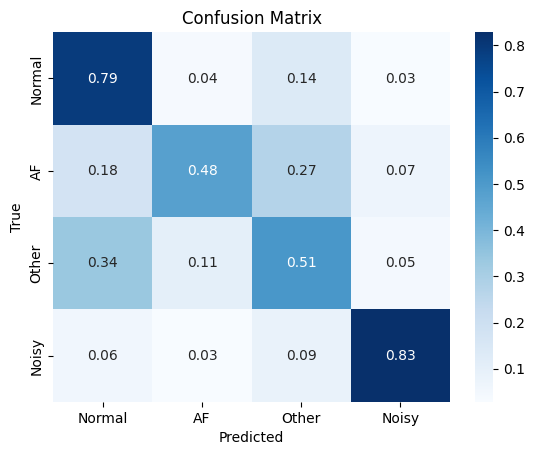

Weighted F1 score of VorgabeRNN with dropout 0.1, hidden_size 128 and learning rate 0.001: 0.6865

Testing VorgabeLSTM with dropout 0.1, hidden_size 128 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 33.19it/s]


Epoch 1: Train Loss: 1.2017, Train Acc: 57.37%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 30.13it/s]


Epoch 2: Train Loss: 1.0238, Train Acc: 59.46%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 30.61it/s]


Epoch 3: Train Loss: 1.0139, Train Acc: 59.16%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 32.69it/s]


Epoch 4: Train Loss: 0.9881, Train Acc: 60.32%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 33.17it/s]


Epoch 5: Train Loss: 0.9781, Train Acc: 59.96%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 33.02it/s]


Epoch 6: Train Loss: 0.9616, Train Acc: 61.31%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 29.96it/s]


Epoch 7: Train Loss: 0.9580, Train Acc: 62.41%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 30.11it/s]


Epoch 8: Train Loss: 0.9205, Train Acc: 64.07%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 32.55it/s]


Epoch 9: Train Loss: 0.9370, Train Acc: 62.53%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 33.04it/s]


Epoch 10: Train Loss: 0.8971, Train Acc: 64.20%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 33.09it/s]


Epoch 11: Train Loss: 0.9088, Train Acc: 64.43%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 30.19it/s]


Epoch 12: Train Loss: 0.8837, Train Acc: 65.21%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 30.07it/s]


Epoch 13: Train Loss: 0.8603, Train Acc: 66.39%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 33.07it/s]


Epoch 14: Train Loss: 0.8734, Train Acc: 66.15%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 32.87it/s]


Epoch 15: Train Loss: 0.8306, Train Acc: 67.19%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 32.91it/s]


Epoch 16: Train Loss: 0.8328, Train Acc: 67.50%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 30.16it/s]


Epoch 17: Train Loss: 0.8083, Train Acc: 68.13%


Epoch 18/20: 100%|██████████| 83/83 [00:03<00:00, 25.93it/s]


Epoch 18: Train Loss: 0.7941, Train Acc: 67.96%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 32.80it/s]


Epoch 19: Train Loss: 0.7631, Train Acc: 69.73%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 32.49it/s]


Epoch 20: Train Loss: 0.7650, Train Acc: 69.44%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 57.75it/s]


Final Validation Accuracy: 0.3053
              precision    recall  f1-score   support

           0       0.70      0.13      0.22       544
           1       0.04      0.04      0.04        84
           2       0.32      0.73      0.44       264
           3       0.12      0.46      0.19        35

    accuracy                           0.31       927
   macro avg       0.29      0.34      0.22       927
weighted avg       0.51      0.31      0.27       927

Final Validation F1 Score: 0.2667


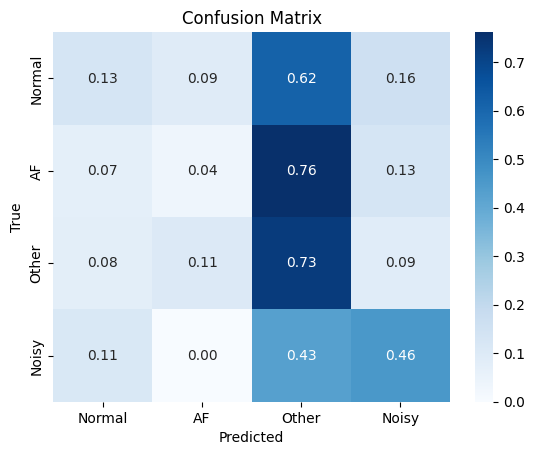

Weighted F1 score of VorgabeLSTM with dropout 0.1, hidden_size 128 and learning rate 0.001: 0.2667

Testing VorgabeGRU with dropout 0.1, hidden_size 128 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 31.60it/s]


Epoch 1: Train Loss: 1.3372, Train Acc: 57.22%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 29.29it/s]


Epoch 2: Train Loss: 1.0218, Train Acc: 59.08%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 33.11it/s]


Epoch 3: Train Loss: 0.9955, Train Acc: 59.88%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 33.32it/s]


Epoch 4: Train Loss: 0.9737, Train Acc: 60.43%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 33.24it/s]


Epoch 5: Train Loss: 0.9536, Train Acc: 61.94%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 32.01it/s]


Epoch 6: Train Loss: 0.9195, Train Acc: 62.93%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 29.50it/s]


Epoch 7: Train Loss: 0.8948, Train Acc: 65.06%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 33.37it/s]


Epoch 8: Train Loss: 0.8960, Train Acc: 64.55%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 33.32it/s]


Epoch 9: Train Loss: 0.8436, Train Acc: 66.37%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 33.21it/s]


Epoch 10: Train Loss: 0.8207, Train Acc: 67.19%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 31.67it/s]


Epoch 11: Train Loss: 0.8214, Train Acc: 67.29%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 28.91it/s]


Epoch 12: Train Loss: 0.7926, Train Acc: 68.49%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 33.45it/s]


Epoch 13: Train Loss: 0.7774, Train Acc: 68.95%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 33.19it/s]


Epoch 14: Train Loss: 0.7503, Train Acc: 70.79%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 33.21it/s]


Epoch 15: Train Loss: 0.7187, Train Acc: 70.91%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 32.06it/s]


Epoch 16: Train Loss: 0.6766, Train Acc: 72.75%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 28.87it/s]


Epoch 17: Train Loss: 0.6680, Train Acc: 73.53%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 33.15it/s]


Epoch 18: Train Loss: 0.6138, Train Acc: 75.48%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 33.33it/s]


Epoch 19: Train Loss: 0.6205, Train Acc: 74.81%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 32.25it/s]


Epoch 20: Train Loss: 0.5369, Train Acc: 77.59%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 59.01it/s]


Final Validation Accuracy: 0.6688
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       544
           1       0.33      0.46      0.39        84
           2       0.57      0.32      0.41       264
           3       0.72      0.51      0.60        35

    accuracy                           0.67       927
   macro avg       0.59      0.54      0.55       927
weighted avg       0.66      0.67      0.65       927

Final Validation F1 Score: 0.6501


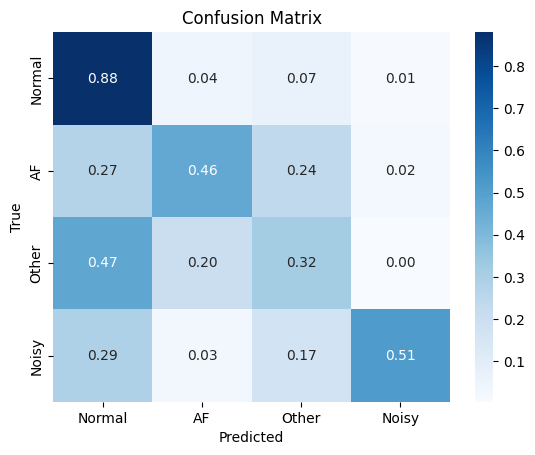

Weighted F1 score of VorgabeGRU with dropout 0.1, hidden_size 128 and learning rate 0.001: 0.6501

Testing VorgabeRNN with dropout 0.1, hidden_size 128 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 31.75it/s]


Epoch 1: Train Loss: 1.6816, Train Acc: 46.90%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 30.42it/s]


Epoch 2: Train Loss: 1.1689, Train Acc: 53.20%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 34.45it/s]


Epoch 3: Train Loss: 1.0484, Train Acc: 56.85%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 33.74it/s]


Epoch 4: Train Loss: 1.0050, Train Acc: 58.64%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 34.43it/s]


Epoch 5: Train Loss: 0.9641, Train Acc: 60.62%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 32.47it/s]


Epoch 6: Train Loss: 0.9469, Train Acc: 62.13%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 30.10it/s]


Epoch 7: Train Loss: 0.9460, Train Acc: 61.92%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 34.33it/s]


Epoch 8: Train Loss: 0.8885, Train Acc: 64.45%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 33.82it/s]


Epoch 9: Train Loss: 0.8759, Train Acc: 65.40%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 34.44it/s]


Epoch 10: Train Loss: 0.8678, Train Acc: 65.61%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 33.16it/s]


Epoch 11: Train Loss: 0.8619, Train Acc: 64.76%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 29.43it/s]


Epoch 12: Train Loss: 0.8345, Train Acc: 67.06%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 33.65it/s]


Epoch 13: Train Loss: 0.8169, Train Acc: 67.06%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 34.05it/s]


Epoch 14: Train Loss: 0.8143, Train Acc: 67.25%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 34.20it/s]


Epoch 15: Train Loss: 0.7943, Train Acc: 68.20%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 33.77it/s]


Epoch 16: Train Loss: 0.7871, Train Acc: 68.87%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 29.61it/s]


Epoch 17: Train Loss: 0.7693, Train Acc: 69.08%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 28.81it/s]


Epoch 18: Train Loss: 0.7713, Train Acc: 69.29%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 33.91it/s]


Epoch 19: Train Loss: 0.7678, Train Acc: 69.73%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 34.13it/s]


Epoch 20: Train Loss: 0.7650, Train Acc: 69.23%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 56.91it/s]


Final Validation Accuracy: 0.6516
              precision    recall  f1-score   support

           0       0.65      0.98      0.78       544
           1       0.62      0.10      0.16        84
           2       0.67      0.18      0.29       264
           3       0.77      0.49      0.60        35

    accuracy                           0.65       927
   macro avg       0.68      0.43      0.46       927
weighted avg       0.65      0.65      0.58       927

Final Validation F1 Score: 0.5757


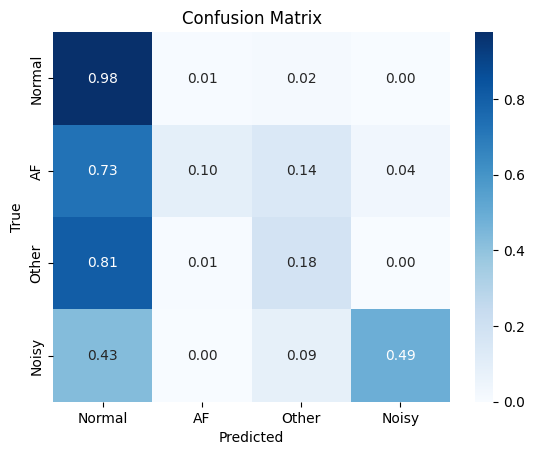

Weighted F1 score of VorgabeRNN with dropout 0.1, hidden_size 128 and learning rate 0.0001: 0.5757

Testing VorgabeLSTM with dropout 0.1, hidden_size 128 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 30.45it/s]


Epoch 1: Train Loss: 1.1226, Train Acc: 56.28%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 28.93it/s]


Epoch 2: Train Loss: 1.0105, Train Acc: 59.22%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 31.99it/s]


Epoch 3: Train Loss: 0.9578, Train Acc: 62.26%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 32.27it/s]


Epoch 4: Train Loss: 0.9331, Train Acc: 62.81%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 32.30it/s]


Epoch 5: Train Loss: 0.8997, Train Acc: 64.47%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.58it/s]


Epoch 6: Train Loss: 0.8703, Train Acc: 65.12%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 29.19it/s]


Epoch 7: Train Loss: 0.8861, Train Acc: 64.15%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 32.25it/s]


Epoch 8: Train Loss: 0.8456, Train Acc: 66.32%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 32.30it/s]


Epoch 9: Train Loss: 0.8407, Train Acc: 65.78%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 32.17it/s]


Epoch 10: Train Loss: 0.8334, Train Acc: 66.49%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 29.52it/s]


Epoch 11: Train Loss: 0.8368, Train Acc: 66.09%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 29.67it/s]


Epoch 12: Train Loss: 0.8109, Train Acc: 67.67%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 32.48it/s]


Epoch 13: Train Loss: 0.8037, Train Acc: 67.76%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 32.08it/s]


Epoch 14: Train Loss: 0.8022, Train Acc: 68.55%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 31.94it/s]


Epoch 15: Train Loss: 0.7787, Train Acc: 68.56%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 29.40it/s]


Epoch 16: Train Loss: 0.7801, Train Acc: 68.79%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 29.42it/s]


Epoch 17: Train Loss: 0.7634, Train Acc: 69.10%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 32.26it/s]


Epoch 18: Train Loss: 0.7501, Train Acc: 69.90%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 28.92it/s]


Epoch 19: Train Loss: 0.7303, Train Acc: 70.62%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 31.99it/s]


Epoch 20: Train Loss: 0.7381, Train Acc: 71.67%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 55.69it/s]


Final Validation Accuracy: 0.6386
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       544
           1       0.30      0.57      0.39        84
           2       0.56      0.26      0.35       264
           3       0.59      0.74      0.66        35

    accuracy                           0.64       927
   macro avg       0.55      0.60      0.55       927
weighted avg       0.65      0.64      0.62       927

Final Validation F1 Score: 0.6221


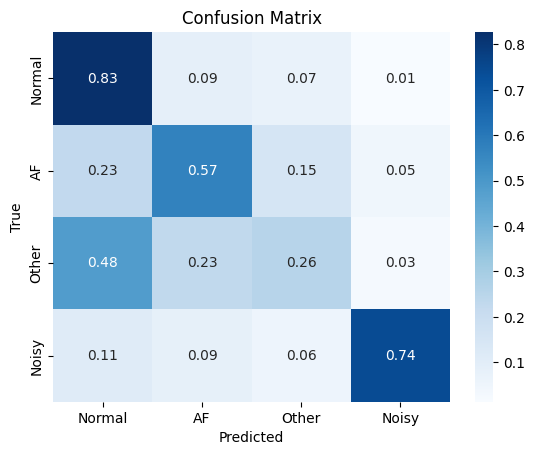

Weighted F1 score of VorgabeLSTM with dropout 0.1, hidden_size 128 and learning rate 0.0001: 0.6221

Testing VorgabeGRU with dropout 0.1, hidden_size 128 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 28.65it/s]


Epoch 1: Train Loss: 1.1706, Train Acc: 55.41%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 32.26it/s]


Epoch 2: Train Loss: 1.0284, Train Acc: 57.90%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 32.92it/s]


Epoch 3: Train Loss: 0.9810, Train Acc: 60.34%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 32.09it/s]


Epoch 4: Train Loss: 0.9403, Train Acc: 61.58%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 30.62it/s]


Epoch 5: Train Loss: 0.9105, Train Acc: 63.71%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.20it/s]


Epoch 6: Train Loss: 0.8938, Train Acc: 64.03%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 32.71it/s]


Epoch 7: Train Loss: 0.8822, Train Acc: 64.51%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 32.68it/s]


Epoch 8: Train Loss: 0.8578, Train Acc: 65.71%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 32.59it/s]


Epoch 9: Train Loss: 0.8435, Train Acc: 65.58%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 30.93it/s]


Epoch 10: Train Loss: 0.8357, Train Acc: 65.67%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 29.66it/s]


Epoch 11: Train Loss: 0.8274, Train Acc: 66.76%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 32.82it/s]


Epoch 12: Train Loss: 0.8078, Train Acc: 68.20%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 32.54it/s]


Epoch 13: Train Loss: 0.8055, Train Acc: 67.54%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 32.68it/s]


Epoch 14: Train Loss: 0.7995, Train Acc: 68.37%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 30.90it/s]


Epoch 15: Train Loss: 0.7865, Train Acc: 68.74%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 29.10it/s]


Epoch 16: Train Loss: 0.7728, Train Acc: 68.77%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 32.39it/s]


Epoch 17: Train Loss: 0.7601, Train Acc: 69.31%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 32.51it/s]


Epoch 18: Train Loss: 0.7620, Train Acc: 69.80%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 32.30it/s]


Epoch 19: Train Loss: 0.7395, Train Acc: 70.73%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 30.65it/s]


Epoch 20: Train Loss: 0.7351, Train Acc: 70.68%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 44.28it/s]


Final Validation Accuracy: 0.6839
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       544
           1       0.47      0.33      0.39        84
           2       0.64      0.29      0.40       264
           3       0.61      0.71      0.66        35

    accuracy                           0.68       927
   macro avg       0.61      0.57      0.56       927
weighted avg       0.67      0.68      0.65       927

Final Validation F1 Score: 0.6475


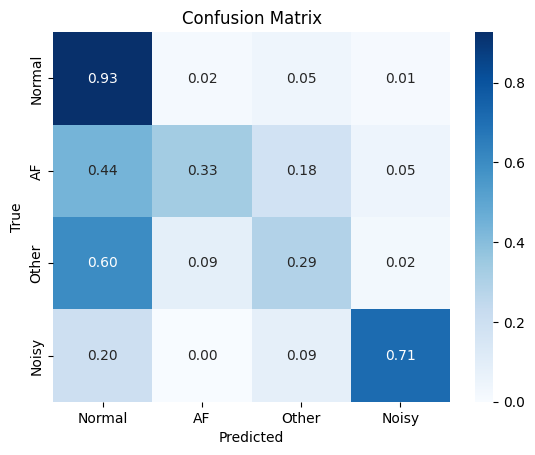

Weighted F1 score of VorgabeGRU with dropout 0.1, hidden_size 128 and learning rate 0.0001: 0.6475

Testing VorgabeRNN with dropout 0.1, hidden_size 256 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 31.49it/s]


Epoch 1: Train Loss: 1.6897, Train Acc: 51.92%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 32.72it/s]


Epoch 2: Train Loss: 1.0106, Train Acc: 57.71%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 33.04it/s]


Epoch 3: Train Loss: 0.9599, Train Acc: 60.72%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 32.44it/s]


Epoch 4: Train Loss: 0.9270, Train Acc: 61.88%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 28.61it/s]


Epoch 5: Train Loss: 0.9374, Train Acc: 62.72%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 32.35it/s]


Epoch 6: Train Loss: 0.8547, Train Acc: 66.26%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 33.07it/s]


Epoch 7: Train Loss: 0.8349, Train Acc: 66.74%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 33.03it/s]


Epoch 8: Train Loss: 0.8106, Train Acc: 67.65%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 32.66it/s]


Epoch 9: Train Loss: 0.7905, Train Acc: 68.43%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 28.05it/s]


Epoch 10: Train Loss: 0.8540, Train Acc: 65.23%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 31.75it/s]


Epoch 11: Train Loss: 0.7827, Train Acc: 68.51%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 33.05it/s]


Epoch 12: Train Loss: 0.7394, Train Acc: 70.16%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 32.91it/s]


Epoch 13: Train Loss: 0.7119, Train Acc: 71.90%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 32.51it/s]


Epoch 14: Train Loss: 0.7219, Train Acc: 71.29%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 28.36it/s]


Epoch 15: Train Loss: 0.6987, Train Acc: 72.20%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 31.68it/s]


Epoch 16: Train Loss: 0.6847, Train Acc: 72.70%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 33.21it/s]


Epoch 17: Train Loss: 0.6256, Train Acc: 74.14%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 32.90it/s]


Epoch 18: Train Loss: 0.6037, Train Acc: 75.86%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 32.57it/s]


Epoch 19: Train Loss: 0.6600, Train Acc: 73.86%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 28.55it/s]


Epoch 20: Train Loss: 0.9319, Train Acc: 62.51%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 40.30it/s]


Final Validation Accuracy: 0.6537
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       544
           1       0.37      0.19      0.25        84
           2       0.49      0.55      0.52       264
           3       0.46      0.49      0.47        35

    accuracy                           0.65       927
   macro avg       0.52      0.50      0.51       927
weighted avg       0.65      0.65      0.65       927

Final Validation F1 Score: 0.6471


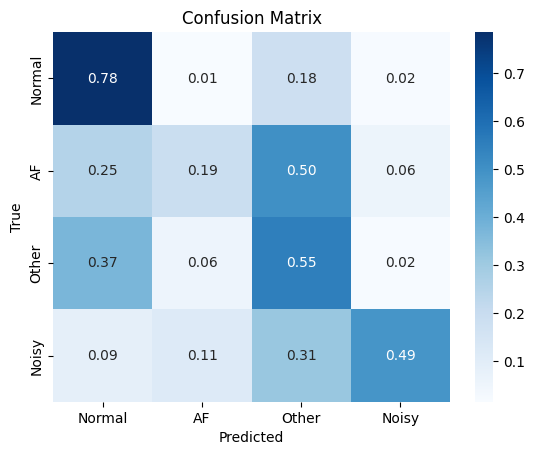

Weighted F1 score of VorgabeRNN with dropout 0.1, hidden_size 256 and learning rate 0.001: 0.6471

Testing VorgabeLSTM with dropout 0.1, hidden_size 256 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 29.83it/s]


Epoch 1: Train Loss: 1.4253, Train Acc: 57.14%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 29.81it/s]


Epoch 2: Train Loss: 1.1176, Train Acc: 58.91%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 29.92it/s]


Epoch 3: Train Loss: 1.1129, Train Acc: 58.91%


Epoch 4/20: 100%|██████████| 83/83 [00:03<00:00, 27.22it/s]


Epoch 4: Train Loss: 1.1137, Train Acc: 58.91%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 28.05it/s]


Epoch 5: Train Loss: 1.1042, Train Acc: 58.91%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 30.00it/s]


Epoch 6: Train Loss: 1.1079, Train Acc: 58.91%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 29.57it/s]


Epoch 7: Train Loss: 1.1114, Train Acc: 58.91%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 28.79it/s]


Epoch 8: Train Loss: 1.0929, Train Acc: 58.91%


Epoch 9/20: 100%|██████████| 83/83 [00:03<00:00, 26.46it/s]


Epoch 9: Train Loss: 1.0391, Train Acc: 59.27%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 29.58it/s]


Epoch 10: Train Loss: 1.0270, Train Acc: 58.99%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 28.99it/s]


Epoch 11: Train Loss: 1.0228, Train Acc: 59.22%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 29.53it/s]


Epoch 12: Train Loss: 1.0167, Train Acc: 58.97%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 27.68it/s]


Epoch 13: Train Loss: 1.0019, Train Acc: 59.52%


Epoch 14/20: 100%|██████████| 83/83 [00:03<00:00, 27.54it/s]


Epoch 14: Train Loss: 0.9839, Train Acc: 59.86%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 29.25it/s]


Epoch 15: Train Loss: 0.9795, Train Acc: 60.21%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 29.64it/s]


Epoch 16: Train Loss: 0.9670, Train Acc: 60.55%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 29.65it/s]


Epoch 17: Train Loss: 0.9388, Train Acc: 61.92%


Epoch 18/20: 100%|██████████| 83/83 [00:03<00:00, 25.74it/s]


Epoch 18: Train Loss: 0.9379, Train Acc: 62.28%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 29.49it/s]


Epoch 19: Train Loss: 0.9065, Train Acc: 63.67%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 29.64it/s]


Epoch 20: Train Loss: 0.9099, Train Acc: 64.13%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 54.36it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5674
              precision    recall  f1-score   support

           0       0.78      0.60      0.68       544
           1       0.00      0.00      0.00        84
           2       0.39      0.72      0.50       264
           3       0.42      0.23      0.30        35

    accuracy                           0.57       927
   macro avg       0.40      0.39      0.37       927
weighted avg       0.59      0.57      0.55       927

Final Validation F1 Score: 0.5549


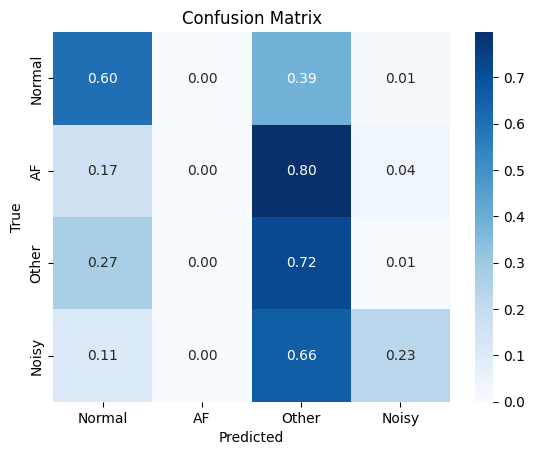

Weighted F1 score of VorgabeLSTM with dropout 0.1, hidden_size 256 and learning rate 0.001: 0.5549

Testing VorgabeGRU with dropout 0.1, hidden_size 256 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 30.74it/s]


Epoch 1: Train Loss: 1.6398, Train Acc: 57.14%


Epoch 2/20: 100%|██████████| 83/83 [00:03<00:00, 27.18it/s]


Epoch 2: Train Loss: 1.0352, Train Acc: 59.04%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 29.02it/s]


Epoch 3: Train Loss: 1.0024, Train Acc: 59.29%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 30.58it/s]


Epoch 4: Train Loss: 0.9908, Train Acc: 60.07%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 30.66it/s]


Epoch 5: Train Loss: 0.9823, Train Acc: 60.62%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.50it/s]


Epoch 6: Train Loss: 0.9524, Train Acc: 62.01%


Epoch 7/20: 100%|██████████| 83/83 [00:03<00:00, 26.58it/s]


Epoch 7: Train Loss: 0.9364, Train Acc: 63.08%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 29.95it/s]


Epoch 8: Train Loss: 0.9163, Train Acc: 63.75%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 30.56it/s]


Epoch 9: Train Loss: 0.8851, Train Acc: 64.85%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 30.41it/s]


Epoch 10: Train Loss: 0.8870, Train Acc: 64.60%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 28.62it/s]


Epoch 11: Train Loss: 0.8847, Train Acc: 65.00%


Epoch 12/20: 100%|██████████| 83/83 [00:03<00:00, 27.54it/s]


Epoch 12: Train Loss: 0.8472, Train Acc: 65.77%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 30.53it/s]


Epoch 13: Train Loss: 0.8395, Train Acc: 66.26%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 30.33it/s]


Epoch 14: Train Loss: 0.8226, Train Acc: 67.27%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 30.20it/s]


Epoch 15: Train Loss: 0.8236, Train Acc: 66.96%


Epoch 16/20: 100%|██████████| 83/83 [00:03<00:00, 27.26it/s]


Epoch 16: Train Loss: 0.8257, Train Acc: 67.02%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 29.30it/s]


Epoch 17: Train Loss: 0.8097, Train Acc: 67.59%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 30.78it/s]


Epoch 18: Train Loss: 0.8163, Train Acc: 66.24%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 30.90it/s]


Epoch 19: Train Loss: 0.7886, Train Acc: 67.54%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 30.15it/s]


Epoch 20: Train Loss: 0.7492, Train Acc: 69.78%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 41.14it/s]


Final Validation Accuracy: 0.6775
              precision    recall  f1-score   support

           0       0.71      0.93      0.80       544
           1       0.47      0.08      0.14        84
           2       0.57      0.38      0.45       264
           3       0.74      0.40      0.52        35

    accuracy                           0.68       927
   macro avg       0.62      0.45      0.48       927
weighted avg       0.65      0.68      0.63       927

Final Validation F1 Score: 0.6332


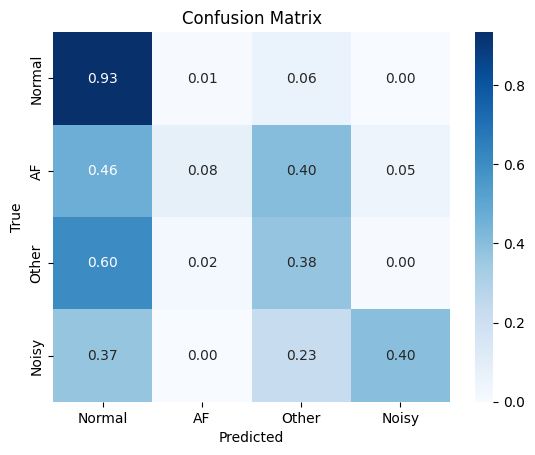

Weighted F1 score of VorgabeGRU with dropout 0.1, hidden_size 256 and learning rate 0.001: 0.6332

Testing VorgabeRNN with dropout 0.1, hidden_size 256 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 28.78it/s]


Epoch 1: Train Loss: 1.4033, Train Acc: 51.83%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 32.22it/s]


Epoch 2: Train Loss: 1.0215, Train Acc: 57.62%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 32.79it/s]


Epoch 3: Train Loss: 0.9658, Train Acc: 60.87%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 32.63it/s]


Epoch 4: Train Loss: 0.9456, Train Acc: 61.96%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 29.33it/s]


Epoch 5: Train Loss: 0.9101, Train Acc: 63.80%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.96it/s]


Epoch 6: Train Loss: 0.8818, Train Acc: 64.55%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 32.11it/s]


Epoch 7: Train Loss: 0.8949, Train Acc: 63.37%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 32.90it/s]


Epoch 8: Train Loss: 0.8259, Train Acc: 66.74%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 32.09it/s]


Epoch 9: Train Loss: 0.8340, Train Acc: 66.72%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 29.72it/s]


Epoch 10: Train Loss: 0.8137, Train Acc: 67.33%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 30.05it/s]


Epoch 11: Train Loss: 0.8099, Train Acc: 67.33%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 32.38it/s]


Epoch 12: Train Loss: 0.7854, Train Acc: 68.70%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 32.48it/s]


Epoch 13: Train Loss: 0.7642, Train Acc: 69.27%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 32.42it/s]


Epoch 14: Train Loss: 0.7637, Train Acc: 69.21%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 29.79it/s]


Epoch 15: Train Loss: 0.7317, Train Acc: 70.09%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 29.84it/s]


Epoch 16: Train Loss: 0.7291, Train Acc: 70.89%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 32.61it/s]


Epoch 17: Train Loss: 0.7078, Train Acc: 71.69%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 31.93it/s]


Epoch 18: Train Loss: 0.7028, Train Acc: 72.11%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 32.38it/s]


Epoch 19: Train Loss: 0.7207, Train Acc: 72.35%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 29.84it/s]


Epoch 20: Train Loss: 0.7060, Train Acc: 71.44%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 46.98it/s]


Final Validation Accuracy: 0.6872
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       544
           1       0.55      0.21      0.31        84
           2       0.63      0.32      0.42       264
           3       0.63      0.77      0.69        35

    accuracy                           0.69       927
   macro avg       0.63      0.56      0.56       927
weighted avg       0.67      0.69      0.65       927

Final Validation F1 Score: 0.6471


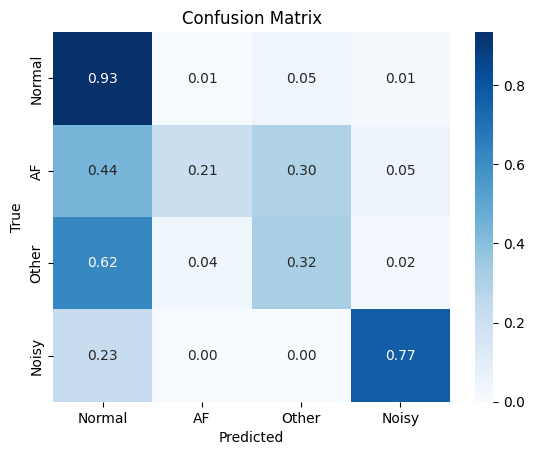

Weighted F1 score of VorgabeRNN with dropout 0.1, hidden_size 256 and learning rate 0.0001: 0.6471

Testing VorgabeLSTM with dropout 0.1, hidden_size 256 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 28.07it/s]


Epoch 1: Train Loss: 1.1788, Train Acc: 55.06%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 29.00it/s]


Epoch 2: Train Loss: 1.0336, Train Acc: 59.08%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 29.59it/s]


Epoch 3: Train Loss: 0.9694, Train Acc: 60.95%


Epoch 4/20: 100%|██████████| 83/83 [00:03<00:00, 27.40it/s]


Epoch 4: Train Loss: 0.9344, Train Acc: 62.07%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 27.68it/s]


Epoch 5: Train Loss: 0.9109, Train Acc: 63.54%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.07it/s]


Epoch 6: Train Loss: 0.8805, Train Acc: 64.58%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 29.48it/s]


Epoch 7: Train Loss: 0.8768, Train Acc: 64.47%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 29.15it/s]


Epoch 8: Train Loss: 0.8633, Train Acc: 65.67%


Epoch 9/20: 100%|██████████| 83/83 [00:03<00:00, 25.60it/s]


Epoch 9: Train Loss: 0.8492, Train Acc: 65.63%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 28.93it/s]


Epoch 10: Train Loss: 0.8502, Train Acc: 66.24%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 29.16it/s]


Epoch 11: Train Loss: 0.8274, Train Acc: 67.17%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 29.05it/s]


Epoch 12: Train Loss: 0.8039, Train Acc: 68.45%


Epoch 13/20: 100%|██████████| 83/83 [00:03<00:00, 27.21it/s]


Epoch 13: Train Loss: 0.7995, Train Acc: 68.30%


Epoch 14/20: 100%|██████████| 83/83 [00:03<00:00, 26.42it/s]


Epoch 14: Train Loss: 0.7866, Train Acc: 69.29%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 29.26it/s]


Epoch 15: Train Loss: 0.7693, Train Acc: 69.61%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 29.06it/s]


Epoch 16: Train Loss: 0.7575, Train Acc: 70.18%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 28.89it/s]


Epoch 17: Train Loss: 0.7531, Train Acc: 70.09%


Epoch 18/20: 100%|██████████| 83/83 [00:03<00:00, 25.30it/s]


Epoch 18: Train Loss: 0.7468, Train Acc: 70.64%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 29.16it/s]


Epoch 19: Train Loss: 0.7197, Train Acc: 70.91%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 29.52it/s]


Epoch 20: Train Loss: 0.7330, Train Acc: 71.92%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 53.30it/s]


Final Validation Accuracy: 0.5933
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       544
           1       0.21      0.76      0.33        84
           2       0.68      0.25      0.36       264
           3       0.53      0.80      0.64        35

    accuracy                           0.59       927
   macro avg       0.56      0.63      0.52       927
weighted avg       0.72      0.59      0.61       927

Final Validation F1 Score: 0.6088


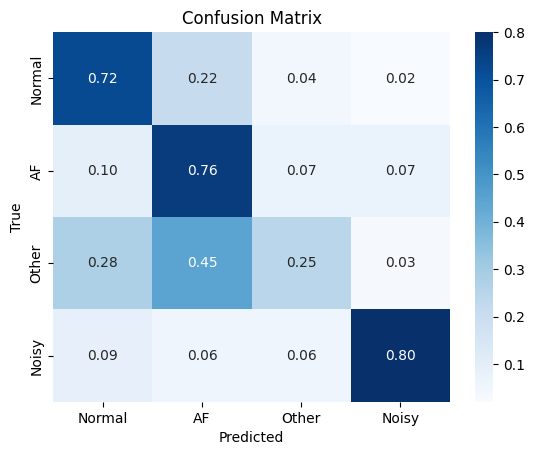

Weighted F1 score of VorgabeLSTM with dropout 0.1, hidden_size 256 and learning rate 0.0001: 0.6088

Testing VorgabeGRU with dropout 0.1, hidden_size 256 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 29.41it/s]


Epoch 1: Train Loss: 1.1063, Train Acc: 56.42%


Epoch 2/20: 100%|██████████| 83/83 [00:03<00:00, 27.07it/s]


Epoch 2: Train Loss: 0.9730, Train Acc: 60.55%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 29.04it/s]


Epoch 3: Train Loss: 0.9128, Train Acc: 63.63%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 30.08it/s]


Epoch 4: Train Loss: 0.8798, Train Acc: 63.79%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 29.86it/s]


Epoch 5: Train Loss: 0.8525, Train Acc: 65.65%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.05it/s]


Epoch 6: Train Loss: 0.8197, Train Acc: 67.75%


Epoch 7/20: 100%|██████████| 83/83 [00:03<00:00, 26.84it/s]


Epoch 7: Train Loss: 0.8146, Train Acc: 67.63%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 30.17it/s]


Epoch 8: Train Loss: 0.7951, Train Acc: 68.58%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 30.26it/s]


Epoch 9: Train Loss: 0.7726, Train Acc: 69.21%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 29.85it/s]


Epoch 10: Train Loss: 0.7681, Train Acc: 69.55%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 28.32it/s]


Epoch 11: Train Loss: 0.7444, Train Acc: 70.53%


Epoch 12/20: 100%|██████████| 83/83 [00:03<00:00, 27.65it/s]


Epoch 12: Train Loss: 0.7279, Train Acc: 71.95%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 29.67it/s]


Epoch 13: Train Loss: 0.7112, Train Acc: 72.22%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 29.49it/s]


Epoch 14: Train Loss: 0.7083, Train Acc: 73.15%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 29.76it/s]


Epoch 15: Train Loss: 0.7018, Train Acc: 71.86%


Epoch 16/20: 100%|██████████| 83/83 [00:03<00:00, 27.48it/s]


Epoch 16: Train Loss: 0.6711, Train Acc: 73.59%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 28.78it/s]


Epoch 17: Train Loss: 0.6516, Train Acc: 74.16%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 30.22it/s]


Epoch 18: Train Loss: 0.6607, Train Acc: 74.09%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 29.60it/s]


Epoch 19: Train Loss: 0.6230, Train Acc: 75.32%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 28.40it/s]


Epoch 20: Train Loss: 0.6083, Train Acc: 76.37%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 40.62it/s]


Final Validation Accuracy: 0.7066
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       544
           1       0.70      0.38      0.49        84
           2       0.77      0.30      0.43       264
           3       0.85      0.49      0.62        35

    accuracy                           0.71       927
   macro avg       0.75      0.53      0.59       927
weighted avg       0.72      0.71      0.67       927

Final Validation F1 Score: 0.6656


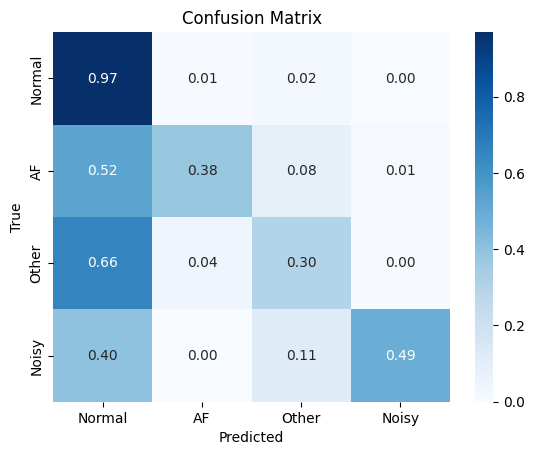

Weighted F1 score of VorgabeGRU with dropout 0.1, hidden_size 256 and learning rate 0.0001: 0.6656

Testing VorgabeRNN with dropout 0.0, hidden_size 128 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 31.79it/s]


Epoch 1: Train Loss: 1.4288, Train Acc: 55.41%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 33.17it/s]


Epoch 2: Train Loss: 1.0319, Train Acc: 58.24%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 33.33it/s]


Epoch 3: Train Loss: 0.9920, Train Acc: 59.33%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 33.43it/s]


Epoch 4: Train Loss: 0.9485, Train Acc: 61.52%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 29.35it/s]


Epoch 5: Train Loss: 0.9383, Train Acc: 63.08%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 31.45it/s]


Epoch 6: Train Loss: 0.9299, Train Acc: 62.70%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 32.89it/s]


Epoch 7: Train Loss: 1.0288, Train Acc: 57.54%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 33.47it/s]


Epoch 8: Train Loss: 0.9355, Train Acc: 61.90%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 33.02it/s]


Epoch 9: Train Loss: 0.8736, Train Acc: 65.23%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 29.76it/s]


Epoch 10: Train Loss: 0.8553, Train Acc: 66.45%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 30.31it/s]


Epoch 11: Train Loss: 0.8446, Train Acc: 65.90%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 33.18it/s]


Epoch 12: Train Loss: 0.8063, Train Acc: 67.90%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 33.02it/s]


Epoch 13: Train Loss: 0.7770, Train Acc: 68.89%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 33.70it/s]


Epoch 14: Train Loss: 0.7642, Train Acc: 69.59%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 30.29it/s]


Epoch 15: Train Loss: 0.7456, Train Acc: 69.88%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 29.80it/s]


Epoch 16: Train Loss: 0.7438, Train Acc: 70.79%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 33.06it/s]


Epoch 17: Train Loss: 0.7156, Train Acc: 71.10%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 33.53it/s]


Epoch 18: Train Loss: 0.6917, Train Acc: 72.87%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 33.78it/s]


Epoch 19: Train Loss: 0.7263, Train Acc: 71.93%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 30.87it/s]


Epoch 20: Train Loss: 0.6951, Train Acc: 72.37%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 41.00it/s]


Final Validation Accuracy: 0.6677
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       544
           1       0.49      0.23      0.31        84
           2       0.55      0.42      0.48       264
           3       0.49      0.57      0.53        35

    accuracy                           0.67       927
   macro avg       0.56      0.52      0.53       927
weighted avg       0.65      0.67      0.65       927

Final Validation F1 Score: 0.6469


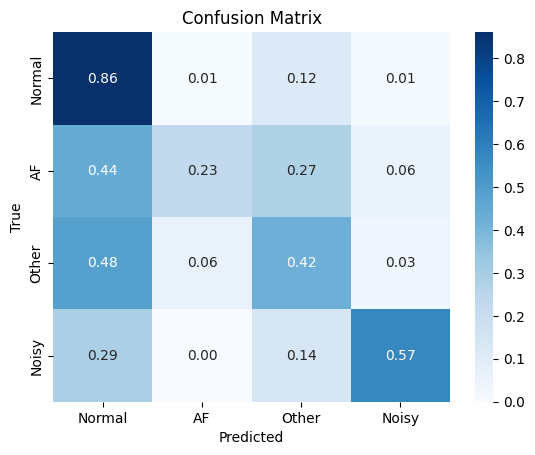

Weighted F1 score of VorgabeRNN with dropout 0.0, hidden_size 128 and learning rate 0.001: 0.6469

Testing VorgabeLSTM with dropout 0.0, hidden_size 128 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 30.69it/s]


Epoch 1: Train Loss: 1.1776, Train Acc: 56.47%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 31.74it/s]


Epoch 2: Train Loss: 1.0223, Train Acc: 59.42%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 31.77it/s]


Epoch 3: Train Loss: 1.0053, Train Acc: 59.84%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 30.17it/s]


Epoch 4: Train Loss: 0.9690, Train Acc: 61.18%


Epoch 5/20: 100%|██████████| 83/83 [00:03<00:00, 27.53it/s]


Epoch 5: Train Loss: 0.9662, Train Acc: 60.83%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 31.78it/s]


Epoch 6: Train Loss: 0.9168, Train Acc: 63.96%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 31.74it/s]


Epoch 7: Train Loss: 0.8897, Train Acc: 65.38%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 31.64it/s]


Epoch 8: Train Loss: 0.9003, Train Acc: 64.68%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 30.52it/s]


Epoch 9: Train Loss: 0.8545, Train Acc: 66.17%


Epoch 10/20: 100%|██████████| 83/83 [00:03<00:00, 27.50it/s]


Epoch 10: Train Loss: 0.8503, Train Acc: 66.26%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 31.47it/s]


Epoch 11: Train Loss: 0.8220, Train Acc: 67.78%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 31.48it/s]


Epoch 12: Train Loss: 0.8077, Train Acc: 67.82%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 31.03it/s]


Epoch 13: Train Loss: 0.7951, Train Acc: 68.75%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 29.81it/s]


Epoch 14: Train Loss: 0.7818, Train Acc: 69.48%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 27.98it/s]


Epoch 15: Train Loss: 0.7497, Train Acc: 70.35%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 31.63it/s]


Epoch 16: Train Loss: 0.7374, Train Acc: 70.85%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 31.81it/s]


Epoch 17: Train Loss: 0.7060, Train Acc: 71.73%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 31.58it/s]


Epoch 18: Train Loss: 0.6964, Train Acc: 71.99%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 29.92it/s]


Epoch 19: Train Loss: 0.6341, Train Acc: 74.26%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 28.23it/s]


Epoch 20: Train Loss: 0.6366, Train Acc: 74.49%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 52.26it/s]


Final Validation Accuracy: 0.4196
              precision    recall  f1-score   support

           0       0.83      0.40      0.54       544
           1       0.14      0.67      0.23        84
           2       0.45      0.37      0.40       264
           3       0.44      0.51      0.47        35

    accuracy                           0.42       927
   macro avg       0.46      0.49      0.41       927
weighted avg       0.65      0.42      0.47       927

Final Validation F1 Score: 0.4711


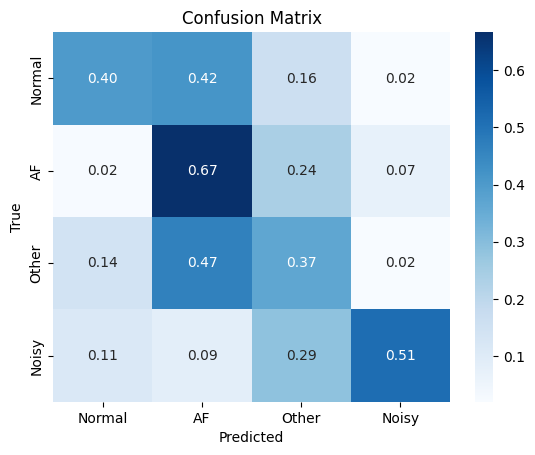

Weighted F1 score of VorgabeLSTM with dropout 0.0, hidden_size 128 and learning rate 0.001: 0.4711

Testing VorgabeGRU with dropout 0.0, hidden_size 128 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 31.87it/s]


Epoch 1: Train Loss: 1.3857, Train Acc: 53.88%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 32.06it/s]


Epoch 2: Train Loss: 1.0806, Train Acc: 58.85%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 32.14it/s]


Epoch 3: Train Loss: 1.0224, Train Acc: 59.16%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 27.75it/s]


Epoch 4: Train Loss: 1.0061, Train Acc: 59.37%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 30.94it/s]


Epoch 5: Train Loss: 0.9701, Train Acc: 61.39%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 32.02it/s]


Epoch 6: Train Loss: 0.9220, Train Acc: 63.00%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 32.67it/s]


Epoch 7: Train Loss: 0.8835, Train Acc: 65.52%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 32.03it/s]


Epoch 8: Train Loss: 0.8824, Train Acc: 65.99%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 28.21it/s]


Epoch 9: Train Loss: 0.8458, Train Acc: 66.57%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 30.51it/s]


Epoch 10: Train Loss: 0.8274, Train Acc: 67.40%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 32.42it/s]


Epoch 11: Train Loss: 0.8343, Train Acc: 67.16%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 32.21it/s]


Epoch 12: Train Loss: 0.7841, Train Acc: 68.89%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 31.73it/s]


Epoch 13: Train Loss: 0.7761, Train Acc: 68.74%


Epoch 14/20: 100%|██████████| 83/83 [00:03<00:00, 27.51it/s]


Epoch 14: Train Loss: 0.7437, Train Acc: 70.66%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 30.42it/s]


Epoch 15: Train Loss: 0.7663, Train Acc: 69.29%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 31.75it/s]


Epoch 16: Train Loss: 0.6912, Train Acc: 72.28%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 31.93it/s]


Epoch 17: Train Loss: 0.6809, Train Acc: 71.71%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 31.33it/s]


Epoch 18: Train Loss: 0.6480, Train Acc: 73.59%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 28.13it/s]


Epoch 19: Train Loss: 0.6181, Train Acc: 75.27%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 31.45it/s]


Epoch 20: Train Loss: 0.5446, Train Acc: 77.91%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 55.32it/s]


Final Validation Accuracy: 0.6591
              precision    recall  f1-score   support

           0       0.69      0.94      0.79       544
           1       0.44      0.33      0.38        84
           2       0.63      0.20      0.30       264
           3       0.54      0.60      0.57        35

    accuracy                           0.66       927
   macro avg       0.57      0.52      0.51       927
weighted avg       0.64      0.66      0.61       927

Final Validation F1 Score: 0.6068


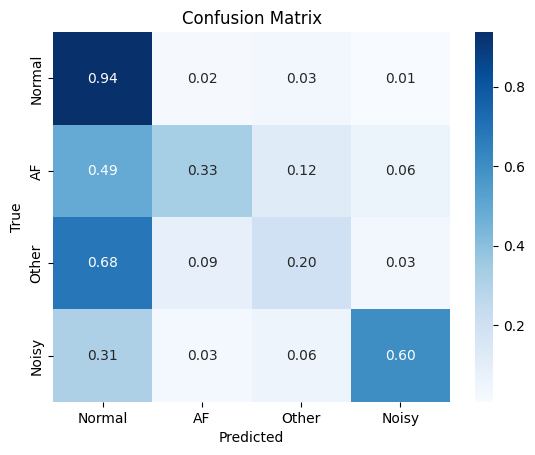

Weighted F1 score of VorgabeGRU with dropout 0.0, hidden_size 128 and learning rate 0.001: 0.6068

Testing VorgabeRNN with dropout 0.0, hidden_size 128 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 33.21it/s]


Epoch 1: Train Loss: 2.0333, Train Acc: 48.93%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 33.69it/s]


Epoch 2: Train Loss: 1.0714, Train Acc: 57.16%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 31.34it/s]


Epoch 3: Train Loss: 1.0189, Train Acc: 59.04%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 29.64it/s]


Epoch 4: Train Loss: 0.9655, Train Acc: 61.06%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 33.59it/s]


Epoch 5: Train Loss: 0.9312, Train Acc: 63.56%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 33.48it/s]


Epoch 6: Train Loss: 0.9020, Train Acc: 63.56%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 33.11it/s]


Epoch 7: Train Loss: 0.9178, Train Acc: 61.71%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 32.20it/s]


Epoch 8: Train Loss: 0.8503, Train Acc: 64.66%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 28.58it/s]


Epoch 9: Train Loss: 0.8494, Train Acc: 66.03%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 33.25it/s]


Epoch 10: Train Loss: 0.8490, Train Acc: 65.35%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 33.29it/s]


Epoch 11: Train Loss: 0.8353, Train Acc: 65.59%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 32.65it/s]


Epoch 12: Train Loss: 0.7962, Train Acc: 67.35%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 33.19it/s]


Epoch 13: Train Loss: 0.7779, Train Acc: 67.99%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 29.47it/s]


Epoch 14: Train Loss: 0.7837, Train Acc: 68.39%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 32.20it/s]


Epoch 15: Train Loss: 0.7547, Train Acc: 69.46%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 33.57it/s]


Epoch 16: Train Loss: 0.7521, Train Acc: 70.43%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 33.32it/s]


Epoch 17: Train Loss: 0.7352, Train Acc: 70.58%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 33.07it/s]


Epoch 18: Train Loss: 0.7290, Train Acc: 71.69%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 29.13it/s]


Epoch 19: Train Loss: 0.7280, Train Acc: 70.89%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 30.86it/s]


Epoch 20: Train Loss: 0.7453, Train Acc: 69.82%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 53.39it/s]


Final Validation Accuracy: 0.6537
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       544
           1       0.26      0.11      0.15        84
           2       0.51      0.52      0.51       264
           3       0.49      0.74      0.59        35

    accuracy                           0.65       927
   macro avg       0.50      0.54      0.51       927
weighted avg       0.63      0.65      0.64       927

Final Validation F1 Score: 0.6402


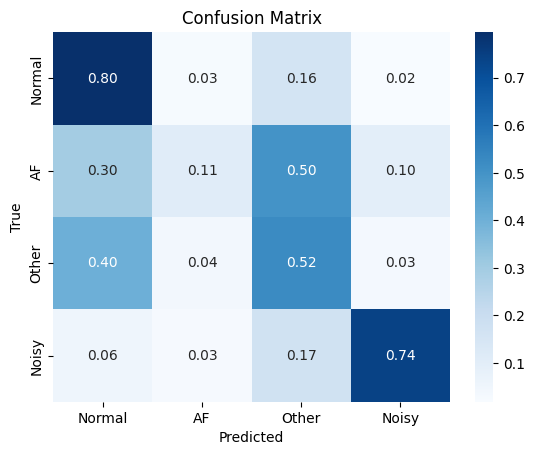

Weighted F1 score of VorgabeRNN with dropout 0.0, hidden_size 128 and learning rate 0.0001: 0.6402

Testing VorgabeLSTM with dropout 0.0, hidden_size 128 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 31.50it/s]


Epoch 1: Train Loss: 1.1054, Train Acc: 55.60%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 32.00it/s]


Epoch 2: Train Loss: 0.9913, Train Acc: 61.06%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 29.47it/s]


Epoch 3: Train Loss: 0.9436, Train Acc: 63.02%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 28.54it/s]


Epoch 4: Train Loss: 0.9145, Train Acc: 64.57%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 31.96it/s]


Epoch 5: Train Loss: 0.8781, Train Acc: 65.25%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 31.93it/s]


Epoch 6: Train Loss: 0.8348, Train Acc: 66.85%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 31.91it/s]


Epoch 7: Train Loss: 0.8151, Train Acc: 67.38%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 30.10it/s]


Epoch 8: Train Loss: 0.7955, Train Acc: 69.04%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 28.89it/s]


Epoch 9: Train Loss: 0.7847, Train Acc: 68.79%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 31.64it/s]


Epoch 10: Train Loss: 0.7925, Train Acc: 69.00%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 31.46it/s]


Epoch 11: Train Loss: 0.7498, Train Acc: 70.37%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 32.17it/s]


Epoch 12: Train Loss: 0.7293, Train Acc: 71.59%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 29.98it/s]


Epoch 13: Train Loss: 0.7220, Train Acc: 71.67%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 28.30it/s]


Epoch 14: Train Loss: 0.6949, Train Acc: 73.46%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 31.73it/s]


Epoch 15: Train Loss: 0.6805, Train Acc: 73.31%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 31.77it/s]


Epoch 16: Train Loss: 0.6605, Train Acc: 74.71%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 32.29it/s]


Epoch 17: Train Loss: 0.6592, Train Acc: 74.41%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 29.80it/s]


Epoch 18: Train Loss: 0.6350, Train Acc: 76.09%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 28.60it/s]


Epoch 19: Train Loss: 0.6025, Train Acc: 76.52%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 31.65it/s]


Epoch 20: Train Loss: 0.6178, Train Acc: 76.64%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 53.22it/s]


Final Validation Accuracy: 0.5879
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       544
           1       0.24      0.71      0.36        84
           2       0.48      0.36      0.41       264
           3       0.56      0.51      0.54        35

    accuracy                           0.59       927
   macro avg       0.53      0.57      0.51       927
weighted avg       0.66      0.59      0.61       927

Final Validation F1 Score: 0.6082


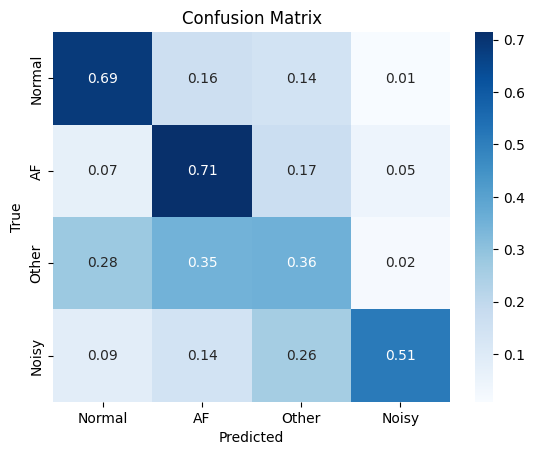

Weighted F1 score of VorgabeLSTM with dropout 0.0, hidden_size 128 and learning rate 0.0001: 0.6082

Testing VorgabeGRU with dropout 0.0, hidden_size 128 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 32.46it/s]


Epoch 1: Train Loss: 1.1182, Train Acc: 57.71%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 32.44it/s]


Epoch 2: Train Loss: 0.9937, Train Acc: 59.90%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 28.27it/s]


Epoch 3: Train Loss: 0.9464, Train Acc: 62.28%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 31.08it/s]


Epoch 4: Train Loss: 0.9098, Train Acc: 63.90%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 32.08it/s]


Epoch 5: Train Loss: 0.8811, Train Acc: 65.08%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 32.53it/s]


Epoch 6: Train Loss: 0.8486, Train Acc: 66.26%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 31.89it/s]


Epoch 7: Train Loss: 0.8259, Train Acc: 66.95%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 28.12it/s]


Epoch 8: Train Loss: 0.8162, Train Acc: 67.08%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 31.22it/s]


Epoch 9: Train Loss: 0.7856, Train Acc: 68.93%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 32.52it/s]


Epoch 10: Train Loss: 0.7764, Train Acc: 68.79%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 32.37it/s]


Epoch 11: Train Loss: 0.7609, Train Acc: 70.13%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 31.96it/s]


Epoch 12: Train Loss: 0.7282, Train Acc: 71.10%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 28.16it/s]


Epoch 13: Train Loss: 0.7169, Train Acc: 70.87%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 30.78it/s]


Epoch 14: Train Loss: 0.7050, Train Acc: 72.70%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 32.60it/s]


Epoch 15: Train Loss: 0.7112, Train Acc: 71.65%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 31.79it/s]


Epoch 16: Train Loss: 0.6767, Train Acc: 73.63%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 32.33it/s]


Epoch 17: Train Loss: 0.6514, Train Acc: 74.05%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 28.26it/s]


Epoch 18: Train Loss: 0.6498, Train Acc: 74.11%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 30.86it/s]


Epoch 19: Train Loss: 0.6234, Train Acc: 75.38%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 31.97it/s]


Epoch 20: Train Loss: 0.6101, Train Acc: 75.84%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 49.04it/s]


Final Validation Accuracy: 0.6828
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       544
           1       0.59      0.19      0.29        84
           2       0.62      0.33      0.43       264
           3       0.64      0.60      0.62        35

    accuracy                           0.68       927
   macro avg       0.64      0.51      0.53       927
weighted avg       0.67      0.68      0.64       927

Final Validation F1 Score: 0.6416


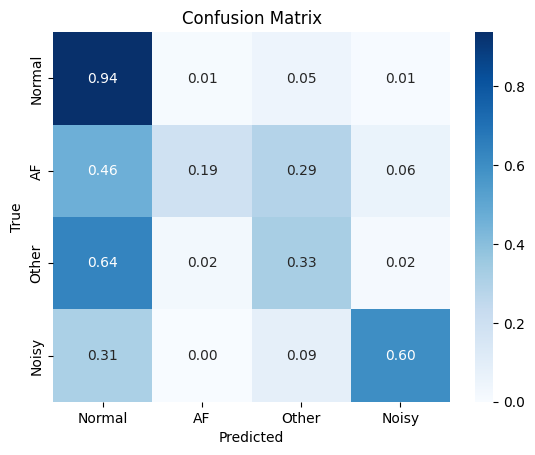

Weighted F1 score of VorgabeGRU with dropout 0.0, hidden_size 128 and learning rate 0.0001: 0.6416

Testing VorgabeRNN with dropout 0.0, hidden_size 256 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 33.28it/s]


Epoch 1: Train Loss: 1.7353, Train Acc: 54.63%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 30.79it/s]


Epoch 2: Train Loss: 1.0386, Train Acc: 57.04%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 29.53it/s]


Epoch 3: Train Loss: 1.0272, Train Acc: 57.65%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 32.13it/s]


Epoch 4: Train Loss: 1.0027, Train Acc: 58.05%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 32.73it/s]


Epoch 5: Train Loss: 1.0082, Train Acc: 58.57%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 33.04it/s]


Epoch 6: Train Loss: 0.9810, Train Acc: 58.99%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 31.85it/s]


Epoch 7: Train Loss: 1.0064, Train Acc: 58.17%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 28.64it/s]


Epoch 8: Train Loss: 0.9665, Train Acc: 60.21%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 32.54it/s]


Epoch 9: Train Loss: 0.9548, Train Acc: 61.61%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 32.78it/s]


Epoch 10: Train Loss: 0.9759, Train Acc: 60.91%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 33.02it/s]


Epoch 11: Train Loss: 0.9612, Train Acc: 61.41%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 32.09it/s]


Epoch 12: Train Loss: 0.9361, Train Acc: 62.72%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 28.14it/s]


Epoch 13: Train Loss: 0.8972, Train Acc: 62.80%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 31.67it/s]


Epoch 14: Train Loss: 0.8817, Train Acc: 65.02%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 32.86it/s]


Epoch 15: Train Loss: 0.8337, Train Acc: 66.49%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 32.70it/s]


Epoch 16: Train Loss: 0.8497, Train Acc: 65.63%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 32.62it/s]


Epoch 17: Train Loss: 0.8012, Train Acc: 67.61%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 27.88it/s]


Epoch 18: Train Loss: 0.7908, Train Acc: 68.09%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 31.38it/s]


Epoch 19: Train Loss: 0.8358, Train Acc: 65.94%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 33.06it/s]


Epoch 20: Train Loss: 0.8612, Train Acc: 65.38%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 54.38it/s]


Final Validation Accuracy: 0.5998
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       544
           1       0.26      0.06      0.10        84
           2       0.42      0.70      0.52       264
           3       0.44      0.43      0.43        35

    accuracy                           0.60       927
   macro avg       0.48      0.46      0.44       927
weighted avg       0.63      0.60      0.60       927

Final Validation F1 Score: 0.5959


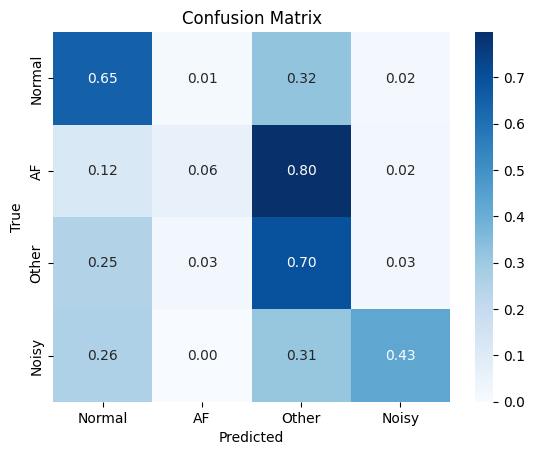

Weighted F1 score of VorgabeRNN with dropout 0.0, hidden_size 256 and learning rate 0.001: 0.5959

Testing VorgabeLSTM with dropout 0.0, hidden_size 256 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 30.07it/s]


Epoch 1: Train Loss: 1.1560, Train Acc: 58.38%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 27.89it/s]


Epoch 2: Train Loss: 1.1186, Train Acc: 58.91%


Epoch 3/20: 100%|██████████| 83/83 [00:03<00:00, 27.43it/s]


Epoch 3: Train Loss: 1.0878, Train Acc: 58.91%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 29.99it/s]


Epoch 4: Train Loss: 1.0817, Train Acc: 58.63%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 29.66it/s]


Epoch 5: Train Loss: 1.0658, Train Acc: 58.83%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.83it/s]


Epoch 6: Train Loss: 1.0892, Train Acc: 58.83%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 27.69it/s]


Epoch 7: Train Loss: 1.0689, Train Acc: 58.82%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 28.44it/s]


Epoch 8: Train Loss: 1.0555, Train Acc: 58.80%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 29.86it/s]


Epoch 9: Train Loss: 1.0530, Train Acc: 59.03%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 29.73it/s]


Epoch 10: Train Loss: 1.0338, Train Acc: 58.91%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 29.82it/s]


Epoch 11: Train Loss: 1.0441, Train Acc: 58.93%


Epoch 12/20: 100%|██████████| 83/83 [00:03<00:00, 26.52it/s]


Epoch 12: Train Loss: 1.0548, Train Acc: 58.95%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 29.11it/s]


Epoch 13: Train Loss: 1.0474, Train Acc: 59.10%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 29.54it/s]


Epoch 14: Train Loss: 1.0197, Train Acc: 59.01%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 29.89it/s]


Epoch 15: Train Loss: 1.0142, Train Acc: 59.03%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 28.36it/s]


Epoch 16: Train Loss: 1.0201, Train Acc: 59.22%


Epoch 17/20: 100%|██████████| 83/83 [00:03<00:00, 27.09it/s]


Epoch 17: Train Loss: 0.9942, Train Acc: 59.46%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 30.00it/s]


Epoch 18: Train Loss: 0.9707, Train Acc: 60.05%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 29.78it/s]


Epoch 19: Train Loss: 0.9460, Train Acc: 61.65%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 30.14it/s]


Epoch 20: Train Loss: 0.9553, Train Acc: 61.82%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 50.97it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5976
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       544
           1       0.00      0.00      0.00        84
           2       0.33      0.02      0.04       264
           3       0.47      0.46      0.46        35

    accuracy                           0.60       927
   macro avg       0.35      0.36      0.31       927
weighted avg       0.47      0.60      0.47       927

Final Validation F1 Score: 0.4676


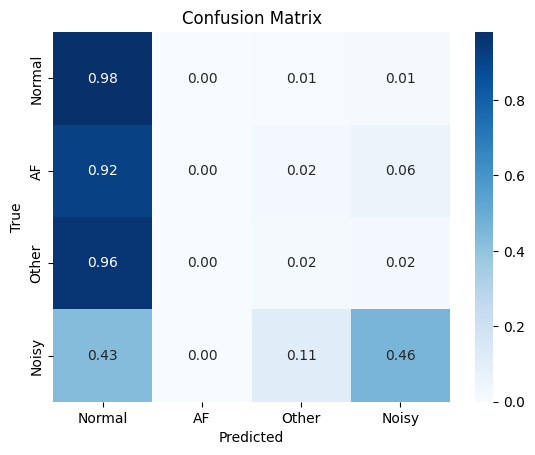

Weighted F1 score of VorgabeLSTM with dropout 0.0, hidden_size 256 and learning rate 0.001: 0.4676

Testing VorgabeGRU with dropout 0.0, hidden_size 256 and learning rate 0.001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:03<00:00, 27.12it/s]


Epoch 1: Train Loss: 1.3096, Train Acc: 57.18%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 30.91it/s]


Epoch 2: Train Loss: 1.1069, Train Acc: 58.91%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 31.30it/s]


Epoch 3: Train Loss: 1.1075, Train Acc: 58.91%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 30.53it/s]


Epoch 4: Train Loss: 1.1102, Train Acc: 58.91%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 29.54it/s]


Epoch 5: Train Loss: 1.1073, Train Acc: 58.91%


Epoch 6/20: 100%|██████████| 83/83 [00:03<00:00, 27.21it/s]


Epoch 6: Train Loss: 1.1114, Train Acc: 58.91%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 31.28it/s]


Epoch 7: Train Loss: 1.1102, Train Acc: 58.91%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 30.77it/s]


Epoch 8: Train Loss: 1.1077, Train Acc: 58.91%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 31.24it/s]


Epoch 9: Train Loss: 1.1073, Train Acc: 58.91%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 28.80it/s]


Epoch 10: Train Loss: 1.1063, Train Acc: 58.91%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 28.00it/s]


Epoch 11: Train Loss: 1.1111, Train Acc: 58.91%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 30.90it/s]


Epoch 12: Train Loss: 1.1043, Train Acc: 58.91%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 31.12it/s]


Epoch 13: Train Loss: 1.1075, Train Acc: 58.91%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 31.31it/s]


Epoch 14: Train Loss: 1.1119, Train Acc: 58.91%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 28.65it/s]


Epoch 15: Train Loss: 1.1053, Train Acc: 58.91%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 28.53it/s]


Epoch 16: Train Loss: 1.1069, Train Acc: 58.91%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 30.84it/s]


Epoch 17: Train Loss: 1.1174, Train Acc: 58.91%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 31.15it/s]


Epoch 18: Train Loss: 1.1174, Train Acc: 58.91%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 30.88it/s]


Epoch 19: Train Loss: 1.1058, Train Acc: 58.91%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 27.84it/s]


Epoch 20: Train Loss: 1.1022, Train Acc: 58.91%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 40.12it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5868
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.00      0.00      0.00        35

    accuracy                           0.59       927
   macro avg       0.15      0.25      0.18       927
weighted avg       0.34      0.59      0.43       927

Final Validation F1 Score: 0.4340


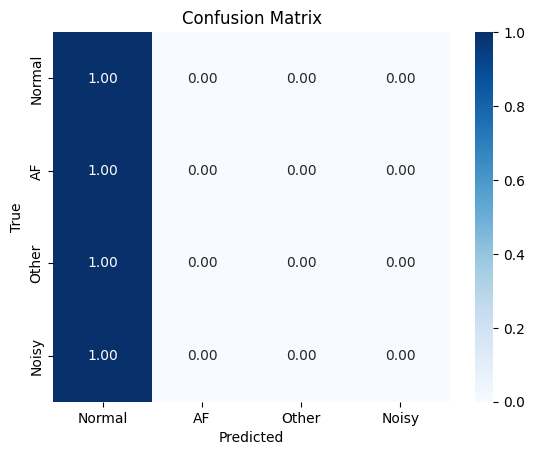

Weighted F1 score of VorgabeGRU with dropout 0.0, hidden_size 256 and learning rate 0.001: 0.4340

Testing VorgabeRNN with dropout 0.0, hidden_size 256 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 32.04it/s]


Epoch 1: Train Loss: 1.2176, Train Acc: 54.51%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 33.09it/s]


Epoch 2: Train Loss: 0.9654, Train Acc: 60.68%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 32.42it/s]


Epoch 3: Train Loss: 0.9007, Train Acc: 64.28%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 31.09it/s]


Epoch 4: Train Loss: 0.8451, Train Acc: 66.17%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 28.33it/s]


Epoch 5: Train Loss: 0.8393, Train Acc: 66.53%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 32.55it/s]


Epoch 6: Train Loss: 0.8060, Train Acc: 67.90%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 32.55it/s]


Epoch 7: Train Loss: 0.7894, Train Acc: 67.75%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 32.67it/s]


Epoch 8: Train Loss: 0.7247, Train Acc: 70.72%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 31.66it/s]


Epoch 9: Train Loss: 0.6992, Train Acc: 72.09%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 27.73it/s]


Epoch 10: Train Loss: 0.6985, Train Acc: 71.67%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 32.70it/s]


Epoch 11: Train Loss: 0.6717, Train Acc: 72.75%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 31.90it/s]


Epoch 12: Train Loss: 0.6308, Train Acc: 74.71%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 32.74it/s]


Epoch 13: Train Loss: 0.5862, Train Acc: 76.66%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 31.98it/s]


Epoch 14: Train Loss: 0.5908, Train Acc: 76.85%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 28.02it/s]


Epoch 15: Train Loss: 0.5446, Train Acc: 78.66%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 32.05it/s]


Epoch 16: Train Loss: 0.5139, Train Acc: 79.68%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 32.53it/s]


Epoch 17: Train Loss: 0.4986, Train Acc: 80.39%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 32.48it/s]


Epoch 18: Train Loss: 0.4566, Train Acc: 82.92%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 33.19it/s]


Epoch 19: Train Loss: 0.4502, Train Acc: 82.69%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 28.80it/s]


Epoch 20: Train Loss: 0.3939, Train Acc: 85.34%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 40.34it/s]


Final Validation Accuracy: 0.6235
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       544
           1       0.45      0.45      0.45        84
           2       0.45      0.57      0.50       264
           3       0.59      0.63      0.61        35

    accuracy                           0.62       927
   macro avg       0.57      0.58      0.57       927
weighted avg       0.65      0.62      0.63       927

Final Validation F1 Score: 0.6328


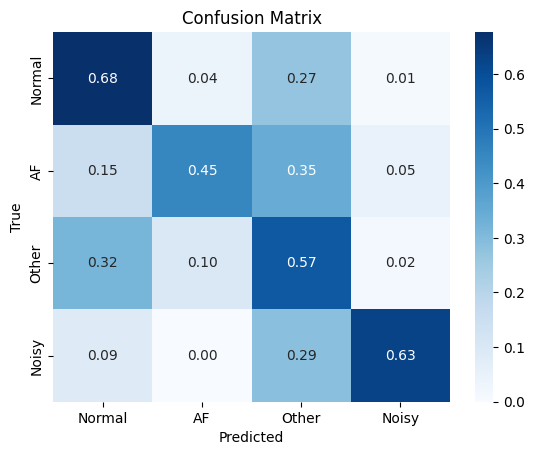

Weighted F1 score of VorgabeRNN with dropout 0.0, hidden_size 256 and learning rate 0.0001: 0.6328

Testing VorgabeLSTM with dropout 0.0, hidden_size 256 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 29.33it/s]


Epoch 1: Train Loss: 1.1177, Train Acc: 57.71%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 29.68it/s]


Epoch 2: Train Loss: 1.0038, Train Acc: 59.65%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 29.96it/s]


Epoch 3: Train Loss: 0.9607, Train Acc: 62.24%


Epoch 4/20: 100%|██████████| 83/83 [00:03<00:00, 26.28it/s]


Epoch 4: Train Loss: 0.9220, Train Acc: 63.33%


Epoch 5/20: 100%|██████████| 83/83 [00:03<00:00, 27.63it/s]


Epoch 5: Train Loss: 0.8744, Train Acc: 65.23%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.16it/s]


Epoch 6: Train Loss: 0.8212, Train Acc: 67.31%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 29.77it/s]


Epoch 7: Train Loss: 0.8217, Train Acc: 66.95%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 29.32it/s]


Epoch 8: Train Loss: 0.7928, Train Acc: 68.83%


Epoch 9/20: 100%|██████████| 83/83 [00:03<00:00, 25.66it/s]


Epoch 9: Train Loss: 0.7826, Train Acc: 68.85%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 29.73it/s]


Epoch 10: Train Loss: 0.7984, Train Acc: 68.81%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 29.57it/s]


Epoch 11: Train Loss: 0.7959, Train Acc: 68.64%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 29.61it/s]


Epoch 12: Train Loss: 0.7381, Train Acc: 71.06%


Epoch 13/20: 100%|██████████| 83/83 [00:03<00:00, 27.25it/s]


Epoch 13: Train Loss: 0.7257, Train Acc: 71.50%


Epoch 14/20: 100%|██████████| 83/83 [00:03<00:00, 27.18it/s]


Epoch 14: Train Loss: 0.7141, Train Acc: 71.48%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 30.27it/s]


Epoch 15: Train Loss: 0.6930, Train Acc: 72.20%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 30.15it/s]


Epoch 16: Train Loss: 0.6747, Train Acc: 73.29%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 29.23it/s]


Epoch 17: Train Loss: 0.6704, Train Acc: 73.48%


Epoch 18/20: 100%|██████████| 83/83 [00:03<00:00, 27.07it/s]


Epoch 18: Train Loss: 0.6451, Train Acc: 74.28%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 28.10it/s]


Epoch 19: Train Loss: 0.6134, Train Acc: 75.72%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 29.86it/s]


Epoch 20: Train Loss: 0.6241, Train Acc: 75.80%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 51.76it/s]


Final Validation Accuracy: 0.5642
              precision    recall  f1-score   support

           0       0.85      0.59      0.70       544
           1       0.24      0.62      0.34        84
           2       0.44      0.47      0.45       264
           3       0.57      0.74      0.64        35

    accuracy                           0.56       927
   macro avg       0.52      0.60      0.53       927
weighted avg       0.66      0.56      0.59       927

Final Validation F1 Score: 0.5926


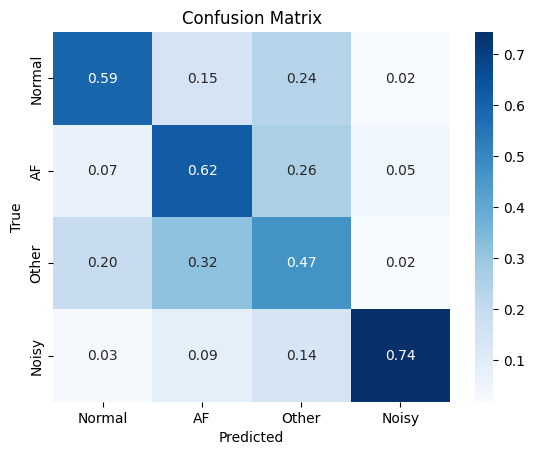

Weighted F1 score of VorgabeLSTM with dropout 0.0, hidden_size 256 and learning rate 0.0001: 0.5926

Testing VorgabeGRU with dropout 0.0, hidden_size 256 and learning rate 0.0001 
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 30.79it/s]


Epoch 1: Train Loss: 1.1730, Train Acc: 56.59%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 29.31it/s]


Epoch 2: Train Loss: 0.9756, Train Acc: 60.85%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 27.77it/s]


Epoch 3: Train Loss: 0.9264, Train Acc: 62.95%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 31.07it/s]


Epoch 4: Train Loss: 0.8966, Train Acc: 64.09%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 30.70it/s]


Epoch 5: Train Loss: 0.8690, Train Acc: 65.94%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 30.75it/s]


Epoch 6: Train Loss: 0.8380, Train Acc: 66.72%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 28.48it/s]


Epoch 7: Train Loss: 0.8181, Train Acc: 68.05%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 28.34it/s]


Epoch 8: Train Loss: 0.8152, Train Acc: 67.16%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 30.04it/s]


Epoch 9: Train Loss: 0.7770, Train Acc: 69.59%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 30.55it/s]


Epoch 10: Train Loss: 0.7810, Train Acc: 68.93%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 30.75it/s]


Epoch 11: Train Loss: 0.7492, Train Acc: 70.58%


Epoch 12/20: 100%|██████████| 83/83 [00:03<00:00, 27.39it/s]


Epoch 12: Train Loss: 0.7238, Train Acc: 71.36%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 28.49it/s]


Epoch 13: Train Loss: 0.7112, Train Acc: 71.65%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 30.41it/s]


Epoch 14: Train Loss: 0.7064, Train Acc: 72.77%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 30.64it/s]


Epoch 15: Train Loss: 0.7029, Train Acc: 71.57%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 30.29it/s]


Epoch 16: Train Loss: 0.6599, Train Acc: 73.82%


Epoch 17/20: 100%|██████████| 83/83 [00:03<00:00, 25.88it/s]


Epoch 17: Train Loss: 0.6464, Train Acc: 73.95%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 29.72it/s]


Epoch 18: Train Loss: 0.6374, Train Acc: 74.37%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 30.41it/s]


Epoch 19: Train Loss: 0.5974, Train Acc: 76.69%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 30.72it/s]


Epoch 20: Train Loss: 0.5819, Train Acc: 77.42%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 50.64it/s]


Final Validation Accuracy: 0.6688
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       544
           1       0.48      0.31      0.38        84
           2       0.67      0.22      0.33       264
           3       0.82      0.51      0.63        35

    accuracy                           0.67       927
   macro avg       0.66      0.50      0.53       927
weighted avg       0.66      0.67      0.62       927

Final Validation F1 Score: 0.6169


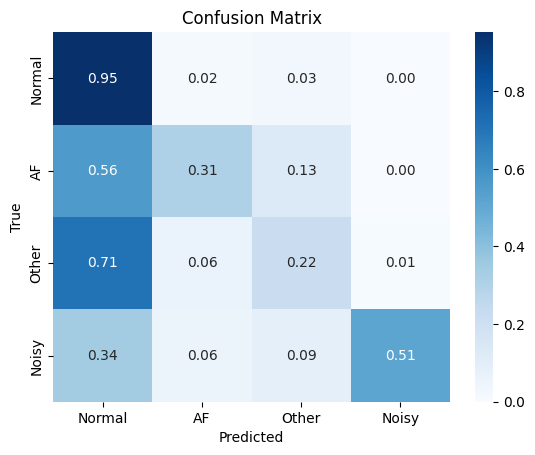

Weighted F1 score of VorgabeGRU with dropout 0.0, hidden_size 256 and learning rate 0.0001: 0.6169

Testing CNNwithSVM
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:09,  8.58it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.79it/s]


Epoch 1: Train Loss: 1.0297, Train Acc: 60.80%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  8.71it/s]


Epoch 2: Train Loss: 0.8790, Train Acc: 67.19%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.86it/s]


Epoch 3: Train Loss: 0.8071, Train Acc: 68.85%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  8.82it/s]


Epoch 4: Train Loss: 0.7560, Train Acc: 71.12%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  8.82it/s]


Epoch 5: Train Loss: 0.7179, Train Acc: 72.72%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  8.85it/s]


Epoch 6: Train Loss: 0.6810, Train Acc: 74.30%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  8.87it/s]


Epoch 7: Train Loss: 0.6736, Train Acc: 74.52%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.75it/s]


Epoch 8: Train Loss: 0.6058, Train Acc: 77.02%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


Epoch 9: Train Loss: 0.5729, Train Acc: 78.18%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.90it/s]


Epoch 10: Train Loss: 0.5794, Train Acc: 78.41%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.81it/s]


Epoch 11: Train Loss: 0.5225, Train Acc: 80.92%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  8.78it/s]


Epoch 12: Train Loss: 0.4880, Train Acc: 82.18%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


Epoch 13: Train Loss: 0.4416, Train Acc: 83.93%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


Epoch 14: Train Loss: 0.4227, Train Acc: 84.52%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.76it/s]


Epoch 15: Train Loss: 0.3616, Train Acc: 87.89%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  8.80it/s]


Epoch 16: Train Loss: 0.3207, Train Acc: 89.95%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.87it/s]


Epoch 17: Train Loss: 0.3002, Train Acc: 90.71%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


Epoch 18: Train Loss: 0.2552, Train Acc: 92.54%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.79it/s]


Epoch 19: Train Loss: 0.2440, Train Acc: 92.88%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.92it/s]


Epoch 20: Train Loss: 0.1862, Train Acc: 95.83%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 49.68it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 27.01it/s]


Final Validation Accuracy: 0.7260
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       544
           1       0.55      0.48      0.51        84
           2       0.59      0.55      0.57       264
           3       0.79      0.54      0.64        35

    accuracy                           0.73       927
   macro avg       0.68      0.61      0.64       927
weighted avg       0.72      0.73      0.72       927

Final Validation F1 Score: 0.7200


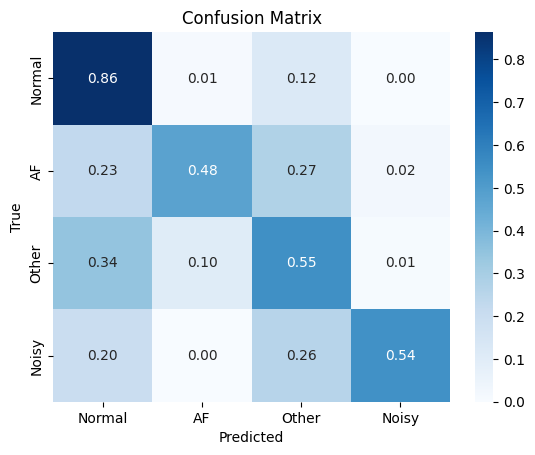

Weighted F1 score of VorgabeGRU: 0.7200

All tests completed.


KeyError: 'dropout'

In [8]:
test_space = {
    "model": [
        VorgabeRNN,
        VorgabeLSTM,
        VorgabeGRU
    ],
    'lr': [0.001, 0.0001],
    'hidden_size': [128, 256],
    'dropout': [0.1, 0.0]
}


results = []
print("Starting tests with different configurations...")

device = "cuda" if torch.cuda.is_available() else "cpu"

for dropout in test_space["dropout"]:
  for hidden_size in test_space["hidden_size"]:
    for lr in test_space["lr"]:
      train_set = ECGDataset(train_df, augmentation=None)
      val_set = ECGDataset(val_df)
      train_loader = DataLoader(train_set,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS,
                                shuffle=True,
                                generator=torch.Generator().manual_seed(42))

      val_loader = DataLoader(val_set,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

      for model_cls in test_space["model"]:
          print(f"Testing {model_cls.__name__} with dropout {dropout}, hidden_size {hidden_size} and learning rate {lr} ")
          model = model_cls(
                  hidden_size=hidden_size,
                  num_layers=1,
                  num_classes=NUM_CLASSES,
                  n_fft=256,
                  hop_length=128,
                  dropout_rate=dropout,
              )
          model.to(device)
          trained_model = train_model(model, train_loader, epochs=20, lr=lr, batch_size_factor=4)
          f1 = evaluate_model(trained_model, val_loader, device)
          print(f"Weighted F1 score of {model_cls.__name__} with dropout {dropout}, hidden_size {hidden_size} and learning rate {lr}: {f1:.4f}\n")
          results.append({
              "model": model_cls.__name__,
              "dropout": dropout,
              "hidden_size": hidden_size,
              "lr": lr,
              "f1": f1,
          })
          del trained_model
          torch.cuda.empty_cache()
      del train_set, val_set, train_loader, val_loader

### CNN+SVM
train_set = ECGDataset(train_df, augmentation=None)
val_set = ECGDataset(val_df)
train_loader = DataLoader(train_set,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(42))

val_loader = DataLoader(val_set,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=False)

print(f"Testing {CNNwithSVM.__name__}")
model = CNNwithSVM(
    feature_size=50,
    num_classes=NUM_CLASSES
)
model.to(device)
trained_model = train_model(model, train_loader, epochs=20, lr=0.001, batch_size_factor=4)
f1 = evaluate_model(trained_model, val_loader, device)
print(f"Weighted F1 score of {model_cls.__name__}: {f1:.4f}\n")
results.append({
    "model": CNNwithSVM,
    "f1": f1,
})
del trained_model
torch.cuda.empty_cache()
del train_set, val_set, train_loader, val_loader


print("All tests completed.")
best_result = max(results, key=lambda x: x["f1"])
if best_result["model"] == CNNwithSVM:
    print(f"Best result:\nModel: {best_result['model']}, F1: {best_result['f1']:.4f}")
else:
    print(f"Best result:\nModel: {best_result['model']}, with dropout {best_result['dropout']}, hidden_size {best_result['hidden_size']} and learning rate {best_result['learning_rate']}:  F1: {best_result['f1']:.4f}")

CNN+SVM looks the most promising architecture, GRU seems to be a good RNN option.

Testing CNNwithSVM
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:13,  5.86it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:08<00:00,  9.36it/s]


Epoch 1: Train Loss: 1.0125, Train Acc: 61.50%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  9.16it/s]


Epoch 2: Train Loss: 0.8326, Train Acc: 68.96%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.62it/s]


Epoch 3: Train Loss: 0.7510, Train Acc: 72.07%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  9.17it/s]


Epoch 4: Train Loss: 0.7047, Train Acc: 73.72%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  9.10it/s]


Epoch 5: Train Loss: 0.6707, Train Acc: 75.27%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  9.14it/s]


Epoch 6: Train Loss: 0.6318, Train Acc: 76.83%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  9.20it/s]


Epoch 7: Train Loss: 0.6110, Train Acc: 77.28%


Epoch 8/20: 100%|██████████| 83/83 [00:08<00:00,  9.25it/s]


Epoch 8: Train Loss: 0.5584, Train Acc: 79.49%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  9.19it/s]


Epoch 9: Train Loss: 0.5315, Train Acc: 80.65%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  9.19it/s]


Epoch 10: Train Loss: 0.5210, Train Acc: 81.09%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.90it/s]


Epoch 11: Train Loss: 0.4707, Train Acc: 83.49%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  9.19it/s]


Epoch 12: Train Loss: 0.4322, Train Acc: 84.84%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  9.18it/s]


Epoch 13: Train Loss: 0.3863, Train Acc: 87.15%


Epoch 14/20: 100%|██████████| 83/83 [00:08<00:00,  9.24it/s]


Epoch 14: Train Loss: 0.3815, Train Acc: 87.00%


Epoch 15/20: 100%|██████████| 83/83 [00:10<00:00,  7.67it/s]


Epoch 15: Train Loss: 0.3086, Train Acc: 90.06%


Epoch 16/20: 100%|██████████| 83/83 [00:10<00:00,  7.88it/s]


Epoch 16: Train Loss: 0.2713, Train Acc: 92.35%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 17: Train Loss: 0.2624, Train Acc: 92.56%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.63it/s]


Epoch 18: Train Loss: 0.1974, Train Acc: 95.68%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.54it/s]


Epoch 19: Train Loss: 0.2459, Train Acc: 92.56%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  9.17it/s]


Epoch 20: Train Loss: 0.1629, Train Acc: 96.40%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 67.70it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 35.33it/s]


Final Validation Accuracy: 0.7400
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       544
           1       0.63      0.56      0.59        84
           2       0.62      0.58      0.60       264
           3       0.74      0.49      0.59        35

    accuracy                           0.74       927
   macro avg       0.70      0.62      0.65       927
weighted avg       0.73      0.74      0.74       927

Final Validation F1 Score: 0.7352


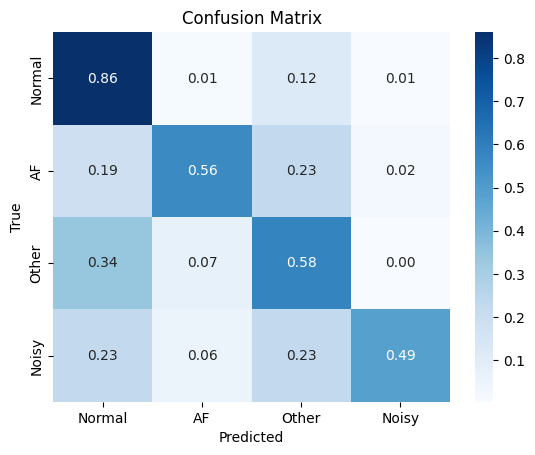

In [16]:
### CNN+SVM
train_set = ECGDataset(train_df, augmentation=None)
val_set = ECGDataset(val_df)
train_loader = DataLoader(train_set,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(42))

val_loader = DataLoader(val_set,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=False)

print(f"Testing {CNNwithSVM.__name__}")
model = CNNwithSVM(
    feature_size=50,
    num_classes=NUM_CLASSES
)
model.to(device)
trained_model = train_model(model, train_loader, epochs=20, lr=0.001, batch_size_factor=4)
f1 = evaluate_model(trained_model, val_loader, device)


In [20]:
test_set = TestECGDataset(test_df)
test_loader = DataLoader(test_set,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=False)
all_predictions = []
trained_model.eval()

with torch.no_grad():
  for signals in tqdm(test_loader):
        signals = signals.unsqueeze(1).to(device)
        features = trained_model.cnn_feature_extractor(signals).cpu().numpy()
        predictions = model.svm.predict(features)
        all_predictions.extend(predictions)

prediction_df = pd.DataFrame(all_predictions)
prediction_df.to_csv("base.csv", index=False)

100%|██████████| 42/42 [00:02<00:00, 16.45it/s]


Starting tests with different configurations...
Testing VorgabeGRU with all
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.77it/s]


Epoch 1: Train Loss: 1.1803, Train Acc: 58.07%


Epoch 2/20: 100%|██████████| 83/83 [00:07<00:00, 11.00it/s]


Epoch 2: Train Loss: 1.0125, Train Acc: 59.27%


Epoch 3/20: 100%|██████████| 83/83 [00:06<00:00, 12.31it/s]


Epoch 3: Train Loss: 0.9974, Train Acc: 59.16%


Epoch 4/20: 100%|██████████| 83/83 [00:07<00:00, 10.64it/s]


Epoch 4: Train Loss: 0.9313, Train Acc: 61.48%


Epoch 5/20: 100%|██████████| 83/83 [00:06<00:00, 12.55it/s]


Epoch 5: Train Loss: 0.9498, Train Acc: 62.47%


Epoch 6/20: 100%|██████████| 83/83 [00:07<00:00, 10.98it/s]


Epoch 6: Train Loss: 0.9194, Train Acc: 63.18%


Epoch 7/20: 100%|██████████| 83/83 [00:06<00:00, 12.48it/s]


Epoch 7: Train Loss: 0.9001, Train Acc: 62.97%


Epoch 8/20: 100%|██████████| 83/83 [00:07<00:00, 10.38it/s]


Epoch 8: Train Loss: 0.8788, Train Acc: 64.58%


Epoch 9/20: 100%|██████████| 83/83 [00:06<00:00, 12.02it/s]


Epoch 9: Train Loss: 0.8724, Train Acc: 65.77%


Epoch 10/20: 100%|██████████| 83/83 [00:07<00:00, 11.16it/s]


Epoch 10: Train Loss: 0.9669, Train Acc: 60.34%


Epoch 11/20: 100%|██████████| 83/83 [00:07<00:00, 11.40it/s]


Epoch 11: Train Loss: 0.9084, Train Acc: 63.65%


Epoch 12/20: 100%|██████████| 83/83 [00:07<00:00, 11.68it/s]


Epoch 12: Train Loss: 0.8854, Train Acc: 64.45%


Epoch 13/20: 100%|██████████| 83/83 [00:07<00:00, 10.88it/s]


Epoch 13: Train Loss: 0.8381, Train Acc: 65.16%


Epoch 14/20: 100%|██████████| 83/83 [00:06<00:00, 12.30it/s]


Epoch 14: Train Loss: 0.8490, Train Acc: 65.97%


Epoch 15/20: 100%|██████████| 83/83 [00:07<00:00, 10.83it/s]


Epoch 15: Train Loss: 0.8057, Train Acc: 67.25%


Epoch 16/20: 100%|██████████| 83/83 [00:06<00:00, 12.30it/s]


Epoch 16: Train Loss: 0.8110, Train Acc: 67.96%


Epoch 17/20: 100%|██████████| 83/83 [00:07<00:00, 10.75it/s]


Epoch 17: Train Loss: 0.7929, Train Acc: 67.63%


Epoch 18/20: 100%|██████████| 83/83 [00:06<00:00, 12.18it/s]


Epoch 18: Train Loss: 0.7785, Train Acc: 68.07%


Epoch 19/20: 100%|██████████| 83/83 [00:07<00:00, 10.98it/s]


Epoch 19: Train Loss: 0.8024, Train Acc: 68.62%


Epoch 20/20: 100%|██████████| 83/83 [00:07<00:00, 11.75it/s]


Epoch 20: Train Loss: 0.8306, Train Acc: 66.55%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 44.64it/s]


Final Validation Accuracy: 0.6839
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       544
           1       0.45      0.29      0.35        84
           2       0.72      0.29      0.41       264
           3       0.48      0.86      0.61        35

    accuracy                           0.68       927
   macro avg       0.59      0.59      0.55       927
weighted avg       0.68      0.68      0.65       927

Final Validation F1 Score: 0.6455


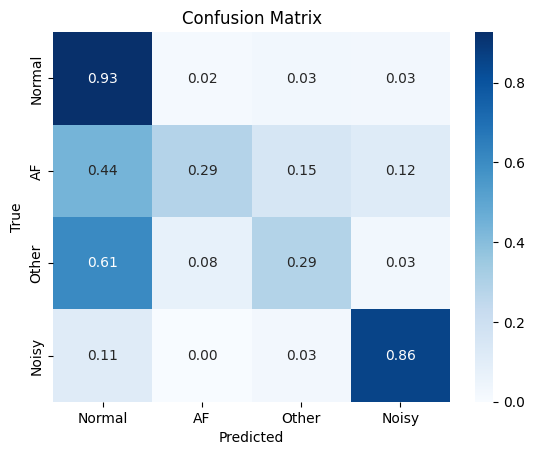

Validation Accuracy of VorgabeGRU with all: 0.6455

Testing CNNwithSVM with all
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   0%|          | 0/83 [00:00<?, ?it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:12<00:00,  6.44it/s]


Epoch 1: Train Loss: 1.0234, Train Acc: 60.64%


Epoch 2/20: 100%|██████████| 83/83 [00:13<00:00,  6.35it/s]


Epoch 2: Train Loss: 0.8769, Train Acc: 66.91%


Epoch 3/20: 100%|██████████| 83/83 [00:12<00:00,  6.39it/s]


Epoch 3: Train Loss: 0.7839, Train Acc: 70.54%


Epoch 4/20: 100%|██████████| 83/83 [00:12<00:00,  6.47it/s]


Epoch 4: Train Loss: 0.7707, Train Acc: 71.36%


Epoch 5/20: 100%|██████████| 83/83 [00:13<00:00,  6.38it/s]


Epoch 5: Train Loss: 0.7410, Train Acc: 71.71%


Epoch 6/20: 100%|██████████| 83/83 [00:12<00:00,  6.52it/s]


Epoch 6: Train Loss: 0.7228, Train Acc: 73.04%


Epoch 7/20: 100%|██████████| 83/83 [00:12<00:00,  6.39it/s]


Epoch 7: Train Loss: 0.7100, Train Acc: 73.42%


Epoch 8/20: 100%|██████████| 83/83 [00:12<00:00,  6.43it/s]


Epoch 8: Train Loss: 0.7104, Train Acc: 72.89%


Epoch 9/20: 100%|██████████| 83/83 [00:12<00:00,  6.47it/s]


Epoch 9: Train Loss: 0.6959, Train Acc: 73.57%


Epoch 10/20: 100%|██████████| 83/83 [00:12<00:00,  6.46it/s]


Epoch 10: Train Loss: 0.6855, Train Acc: 73.48%


Epoch 11/20: 100%|██████████| 83/83 [00:12<00:00,  6.51it/s]


Epoch 11: Train Loss: 0.6750, Train Acc: 74.11%


Epoch 12/20: 100%|██████████| 83/83 [00:12<00:00,  6.44it/s]


Epoch 12: Train Loss: 0.6743, Train Acc: 74.77%


Epoch 13/20: 100%|██████████| 83/83 [00:12<00:00,  6.44it/s]


Epoch 13: Train Loss: 0.6712, Train Acc: 74.68%


Epoch 14/20: 100%|██████████| 83/83 [00:12<00:00,  6.52it/s]


Epoch 14: Train Loss: 0.6533, Train Acc: 75.04%


Epoch 15/20: 100%|██████████| 83/83 [00:12<00:00,  6.45it/s]


Epoch 15: Train Loss: 0.6320, Train Acc: 75.69%


Epoch 16/20: 100%|██████████| 83/83 [00:12<00:00,  6.42it/s]


Epoch 16: Train Loss: 0.6431, Train Acc: 75.63%


Epoch 17/20: 100%|██████████| 83/83 [00:12<00:00,  6.43it/s]


Epoch 17: Train Loss: 0.6265, Train Acc: 75.36%


Epoch 18/20: 100%|██████████| 83/83 [00:12<00:00,  6.43it/s]


Epoch 18: Train Loss: 0.6221, Train Acc: 76.03%


Epoch 19/20: 100%|██████████| 83/83 [00:12<00:00,  6.47it/s]


Epoch 19: Train Loss: 0.5974, Train Acc: 77.38%


Epoch 20/20: 100%|██████████| 83/83 [00:12<00:00,  6.49it/s]


Epoch 20: Train Loss: 0.6293, Train Acc: 76.92%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:05<00:00, 13.91it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 24.02it/s]


Final Validation Accuracy: 0.7616
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       544
           1       0.81      0.50      0.62        84
           2       0.71      0.49      0.58       264
           3       0.65      0.63      0.64        35

    accuracy                           0.76       927
   macro avg       0.74      0.64      0.67       927
weighted avg       0.76      0.76      0.75       927

Final Validation F1 Score: 0.7457


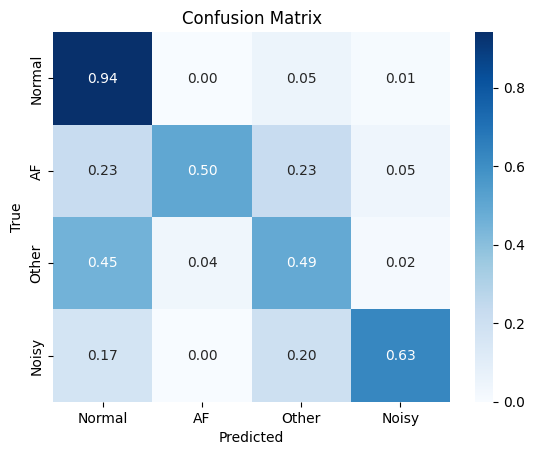

Validation Accuracy of CNNwithSVM with all: 0.7457

Testing VorgabeGRU with noise_only
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:03<00:00, 22.94it/s]


Epoch 1: Train Loss: 1.3142, Train Acc: 54.51%


Epoch 2/20: 100%|██████████| 83/83 [00:04<00:00, 20.68it/s]


Epoch 2: Train Loss: 0.9849, Train Acc: 59.96%


Epoch 3/20: 100%|██████████| 83/83 [00:03<00:00, 24.32it/s]


Epoch 3: Train Loss: 0.9487, Train Acc: 61.23%


Epoch 4/20: 100%|██████████| 83/83 [00:03<00:00, 24.42it/s]


Epoch 4: Train Loss: 0.8963, Train Acc: 63.67%


Epoch 5/20: 100%|██████████| 83/83 [00:03<00:00, 21.63it/s]


Epoch 5: Train Loss: 0.8903, Train Acc: 64.72%


Epoch 6/20: 100%|██████████| 83/83 [00:03<00:00, 22.10it/s]


Epoch 6: Train Loss: 0.8689, Train Acc: 64.87%


Epoch 7/20: 100%|██████████| 83/83 [00:03<00:00, 24.18it/s]


Epoch 7: Train Loss: 0.8752, Train Acc: 65.29%


Epoch 8/20: 100%|██████████| 83/83 [00:03<00:00, 24.10it/s]


Epoch 8: Train Loss: 0.8072, Train Acc: 67.73%


Epoch 9/20: 100%|██████████| 83/83 [00:04<00:00, 20.10it/s]


Epoch 9: Train Loss: 0.8140, Train Acc: 68.28%


Epoch 10/20: 100%|██████████| 83/83 [00:03<00:00, 23.96it/s]


Epoch 10: Train Loss: 0.8583, Train Acc: 64.60%


Epoch 11/20: 100%|██████████| 83/83 [00:03<00:00, 24.42it/s]


Epoch 11: Train Loss: 0.8300, Train Acc: 66.13%


Epoch 12/20: 100%|██████████| 83/83 [00:03<00:00, 23.62it/s]


Epoch 12: Train Loss: 0.7806, Train Acc: 69.00%


Epoch 13/20: 100%|██████████| 83/83 [00:03<00:00, 20.83it/s]


Epoch 13: Train Loss: 0.7681, Train Acc: 68.47%


Epoch 14/20: 100%|██████████| 83/83 [00:03<00:00, 24.51it/s]


Epoch 14: Train Loss: 0.7543, Train Acc: 69.55%


Epoch 15/20: 100%|██████████| 83/83 [00:03<00:00, 24.50it/s]


Epoch 15: Train Loss: 0.7330, Train Acc: 69.97%


Epoch 16/20: 100%|██████████| 83/83 [00:03<00:00, 21.28it/s]


Epoch 16: Train Loss: 0.7523, Train Acc: 69.82%


Epoch 17/20: 100%|██████████| 83/83 [00:03<00:00, 22.16it/s]


Epoch 17: Train Loss: 0.7016, Train Acc: 70.51%


Epoch 18/20: 100%|██████████| 83/83 [00:03<00:00, 23.87it/s]


Epoch 18: Train Loss: 0.6929, Train Acc: 71.92%


Epoch 19/20: 100%|██████████| 83/83 [00:03<00:00, 24.47it/s]


Epoch 19: Train Loss: 0.6925, Train Acc: 72.03%


Epoch 20/20: 100%|██████████| 83/83 [00:04<00:00, 20.13it/s]


Epoch 20: Train Loss: 0.6926, Train Acc: 71.90%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 57.61it/s]


Final Validation Accuracy: 0.6559
              precision    recall  f1-score   support

           0       0.83      0.71      0.76       544
           1       0.45      0.29      0.35        84
           2       0.48      0.66      0.55       264
           3       0.53      0.71      0.61        35

    accuracy                           0.66       927
   macro avg       0.57      0.59      0.57       927
weighted avg       0.68      0.66      0.66       927

Final Validation F1 Score: 0.6608


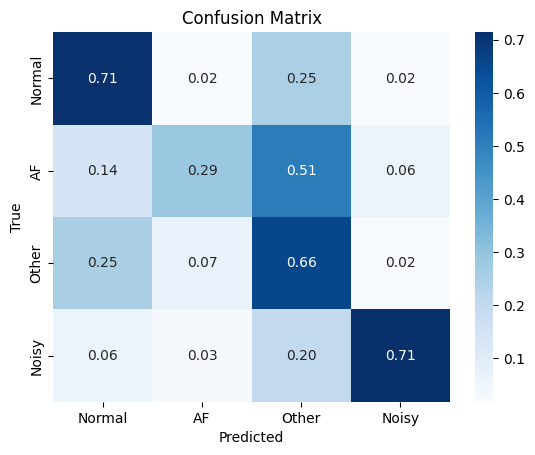

Validation Accuracy of VorgabeGRU with noise_only: 0.6608

Testing CNNwithSVM with noise_only
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:14,  5.61it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:10<00:00,  8.26it/s]


Epoch 1: Train Loss: 0.9984, Train Acc: 61.54%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  8.43it/s]


Epoch 2: Train Loss: 0.8372, Train Acc: 69.15%


Epoch 3/20: 100%|██████████| 83/83 [00:10<00:00,  8.22it/s]


Epoch 3: Train Loss: 0.7523, Train Acc: 72.52%


Epoch 4/20: 100%|██████████| 83/83 [00:10<00:00,  8.26it/s]


Epoch 4: Train Loss: 0.7160, Train Acc: 73.80%


Epoch 5/20: 100%|██████████| 83/83 [00:10<00:00,  8.22it/s]


Epoch 5: Train Loss: 0.6665, Train Acc: 75.13%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  8.49it/s]


Epoch 6: Train Loss: 0.6204, Train Acc: 76.69%


Epoch 7/20: 100%|██████████| 83/83 [00:10<00:00,  8.26it/s]


Epoch 7: Train Loss: 0.5805, Train Acc: 78.81%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.30it/s]


Epoch 8: Train Loss: 0.5513, Train Acc: 79.74%


Epoch 9/20: 100%|██████████| 83/83 [00:10<00:00,  8.20it/s]


Epoch 9: Train Loss: 0.5077, Train Acc: 81.65%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.49it/s]


Epoch 10: Train Loss: 0.4970, Train Acc: 81.76%


Epoch 11/20: 100%|██████████| 83/83 [00:10<00:00,  8.30it/s]


Epoch 11: Train Loss: 0.4607, Train Acc: 83.07%


Epoch 12/20: 100%|██████████| 83/83 [00:10<00:00,  8.22it/s]


Epoch 12: Train Loss: 0.4278, Train Acc: 84.56%


Epoch 13/20: 100%|██████████| 83/83 [00:10<00:00,  8.20it/s]


Epoch 13: Train Loss: 0.3721, Train Acc: 87.51%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.38it/s]


Epoch 14: Train Loss: 0.3290, Train Acc: 89.34%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.34it/s]


Epoch 15: Train Loss: 0.2982, Train Acc: 90.21%


Epoch 16/20: 100%|██████████| 83/83 [00:10<00:00,  8.28it/s]


Epoch 16: Train Loss: 0.2453, Train Acc: 92.99%


Epoch 17/20: 100%|██████████| 83/83 [00:10<00:00,  8.21it/s]


Epoch 17: Train Loss: 0.2202, Train Acc: 94.00%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.35it/s]


Epoch 18: Train Loss: 0.2266, Train Acc: 93.53%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.40it/s]


Epoch 19: Train Loss: 0.1639, Train Acc: 96.17%


Epoch 20/20: 100%|██████████| 83/83 [00:10<00:00,  8.23it/s]


Epoch 20: Train Loss: 0.1414, Train Acc: 97.62%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 38.15it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 36.27it/s]


Final Validation Accuracy: 0.7152
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       544
           1       0.63      0.49      0.55        84
           2       0.56      0.56      0.56       264
           3       0.71      0.49      0.58        35

    accuracy                           0.72       927
   macro avg       0.67      0.59      0.63       927
weighted avg       0.71      0.72      0.71       927

Final Validation F1 Score: 0.7112


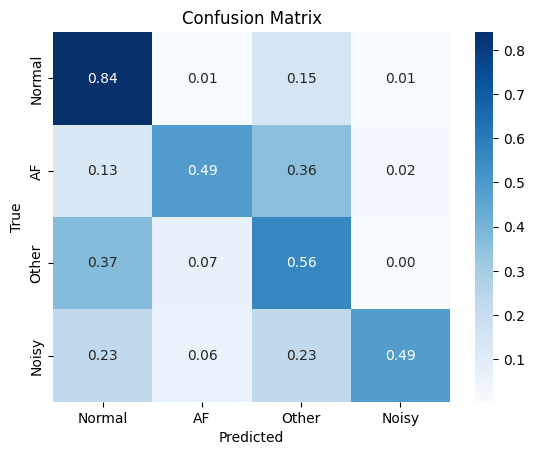

Validation Accuracy of CNNwithSVM with noise_only: 0.7112

Testing VorgabeGRU with shift_only
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:03<00:00, 26.54it/s]


Epoch 1: Train Loss: 1.2913, Train Acc: 57.25%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 31.10it/s]


Epoch 2: Train Loss: 0.9948, Train Acc: 60.00%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 31.47it/s]


Epoch 3: Train Loss: 0.9570, Train Acc: 61.16%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 30.85it/s]


Epoch 4: Train Loss: 0.9521, Train Acc: 61.82%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 30.03it/s]


Epoch 5: Train Loss: 0.9266, Train Acc: 63.77%


Epoch 6/20: 100%|██████████| 83/83 [00:03<00:00, 27.60it/s]


Epoch 6: Train Loss: 0.8914, Train Acc: 63.88%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 30.86it/s]


Epoch 7: Train Loss: 0.9117, Train Acc: 63.02%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 31.08it/s]


Epoch 8: Train Loss: 0.8518, Train Acc: 66.11%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 31.11it/s]


Epoch 9: Train Loss: 0.8652, Train Acc: 66.66%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 28.49it/s]


Epoch 10: Train Loss: 0.9233, Train Acc: 63.63%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 28.01it/s]


Epoch 11: Train Loss: 0.8539, Train Acc: 66.41%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 31.10it/s]


Epoch 12: Train Loss: 0.8247, Train Acc: 67.04%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 31.06it/s]


Epoch 13: Train Loss: 0.8370, Train Acc: 66.36%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 31.11it/s]


Epoch 14: Train Loss: 0.8811, Train Acc: 64.72%


Epoch 15/20: 100%|██████████| 83/83 [00:03<00:00, 27.10it/s]


Epoch 15: Train Loss: 0.8107, Train Acc: 67.92%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 28.93it/s]


Epoch 16: Train Loss: 0.8066, Train Acc: 67.71%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 30.73it/s]


Epoch 17: Train Loss: 0.7918, Train Acc: 68.87%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 31.20it/s]


Epoch 18: Train Loss: 0.7790, Train Acc: 69.50%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 30.43it/s]


Epoch 19: Train Loss: 0.8245, Train Acc: 68.11%


Epoch 20/20: 100%|██████████| 83/83 [00:03<00:00, 26.65it/s]


Epoch 20: Train Loss: 0.7839, Train Acc: 70.05%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 56.27it/s]


Final Validation Accuracy: 0.6807
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       544
           1       0.71      0.14      0.24        84
           2       0.61      0.32      0.42       264
           3       0.57      0.77      0.66        35

    accuracy                           0.68       927
   macro avg       0.65      0.54      0.53       927
weighted avg       0.67      0.68      0.64       927

Final Validation F1 Score: 0.6352


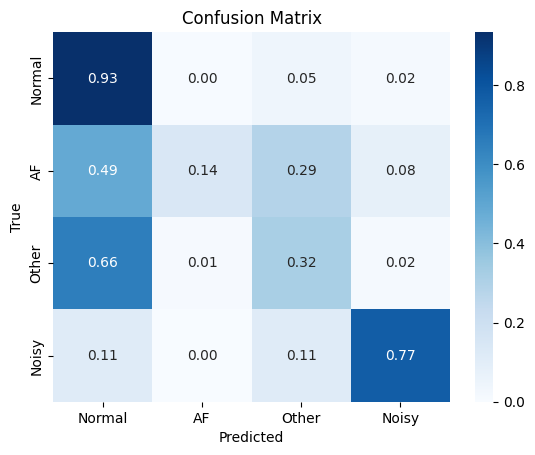

Validation Accuracy of VorgabeGRU with shift_only: 0.6352

Testing CNNwithSVM with shift_only
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:09,  8.58it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.99it/s]


Epoch 1: Train Loss: 1.0225, Train Acc: 60.57%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


Epoch 2: Train Loss: 0.8912, Train Acc: 66.36%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


Epoch 3: Train Loss: 0.8012, Train Acc: 69.92%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  8.91it/s]


Epoch 4: Train Loss: 0.7546, Train Acc: 71.31%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  9.00it/s]


Epoch 5: Train Loss: 0.7347, Train Acc: 72.24%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


Epoch 6: Train Loss: 0.7042, Train Acc: 73.97%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


Epoch 7: Train Loss: 0.6874, Train Acc: 74.12%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  9.03it/s]


Epoch 8: Train Loss: 0.6801, Train Acc: 73.95%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


Epoch 9: Train Loss: 0.6588, Train Acc: 74.71%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.92it/s]


Epoch 10: Train Loss: 0.6314, Train Acc: 76.16%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 11: Train Loss: 0.6275, Train Acc: 76.22%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  8.99it/s]


Epoch 12: Train Loss: 0.6121, Train Acc: 76.77%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  8.91it/s]


Epoch 13: Train Loss: 0.6019, Train Acc: 77.68%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.90it/s]


Epoch 14: Train Loss: 0.5895, Train Acc: 77.91%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  9.04it/s]


Epoch 15: Train Loss: 0.5982, Train Acc: 77.09%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  8.87it/s]


Epoch 16: Train Loss: 0.5781, Train Acc: 78.16%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.92it/s]


Epoch 17: Train Loss: 0.5463, Train Acc: 79.23%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 18: Train Loss: 0.5364, Train Acc: 79.87%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


Epoch 19: Train Loss: 0.5135, Train Acc: 80.56%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.90it/s]


Epoch 20: Train Loss: 0.5210, Train Acc: 80.22%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 57.89it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.61it/s]


Final Validation Accuracy: 0.7767
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       544
           1       0.73      0.55      0.63        84
           2       0.71      0.56      0.63       264
           3       0.71      0.63      0.67        35

    accuracy                           0.78       927
   macro avg       0.74      0.67      0.70       927
weighted avg       0.77      0.78      0.77       927

Final Validation F1 Score: 0.7666


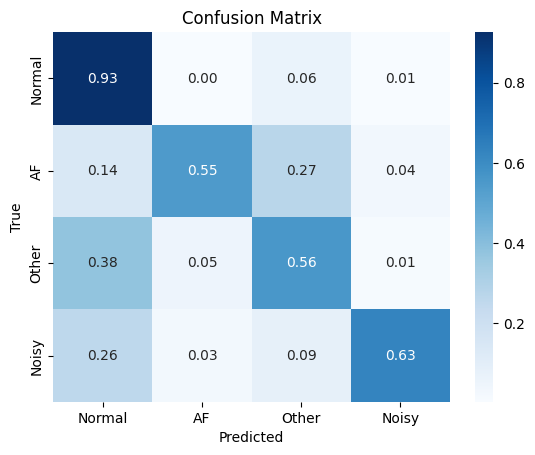

Validation Accuracy of CNNwithSVM with shift_only: 0.7666

Testing VorgabeGRU with scale_only
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 31.58it/s]


Epoch 1: Train Loss: 1.4673, Train Acc: 56.63%


Epoch 2/20: 100%|██████████| 83/83 [00:03<00:00, 27.64it/s]


Epoch 2: Train Loss: 1.0461, Train Acc: 59.01%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 31.88it/s]


Epoch 3: Train Loss: 1.0112, Train Acc: 59.42%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 32.30it/s]


Epoch 4: Train Loss: 0.9893, Train Acc: 59.20%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 31.91it/s]


Epoch 5: Train Loss: 0.9818, Train Acc: 60.34%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 31.45it/s]


Epoch 6: Train Loss: 0.9402, Train Acc: 60.70%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 28.09it/s]


Epoch 7: Train Loss: 0.9492, Train Acc: 61.02%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 31.86it/s]


Epoch 8: Train Loss: 0.8935, Train Acc: 63.14%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 31.93it/s]


Epoch 9: Train Loss: 0.8796, Train Acc: 65.12%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 32.31it/s]


Epoch 10: Train Loss: 0.9281, Train Acc: 62.34%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 31.56it/s]


Epoch 11: Train Loss: 0.8889, Train Acc: 64.19%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 28.10it/s]


Epoch 12: Train Loss: 0.8710, Train Acc: 65.29%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 31.49it/s]


Epoch 13: Train Loss: 0.8392, Train Acc: 65.92%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 32.29it/s]


Epoch 14: Train Loss: 0.8388, Train Acc: 66.87%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 31.88it/s]


Epoch 15: Train Loss: 0.7983, Train Acc: 66.91%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 31.34it/s]


Epoch 16: Train Loss: 0.7798, Train Acc: 68.95%


Epoch 17/20: 100%|██████████| 83/83 [00:03<00:00, 27.49it/s]


Epoch 17: Train Loss: 0.7423, Train Acc: 69.48%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 32.00it/s]


Epoch 18: Train Loss: 0.7361, Train Acc: 70.43%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 32.04it/s]


Epoch 19: Train Loss: 0.7594, Train Acc: 70.24%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 31.95it/s]


Epoch 20: Train Loss: 0.7167, Train Acc: 70.51%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 56.49it/s]


Final Validation Accuracy: 0.6828
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       544
           1       0.40      0.23      0.29        84
           2       0.59      0.34      0.43       264
           3       0.62      0.51      0.56        35

    accuracy                           0.68       927
   macro avg       0.58      0.50      0.52       927
weighted avg       0.65      0.68      0.65       927

Final Validation F1 Score: 0.6494


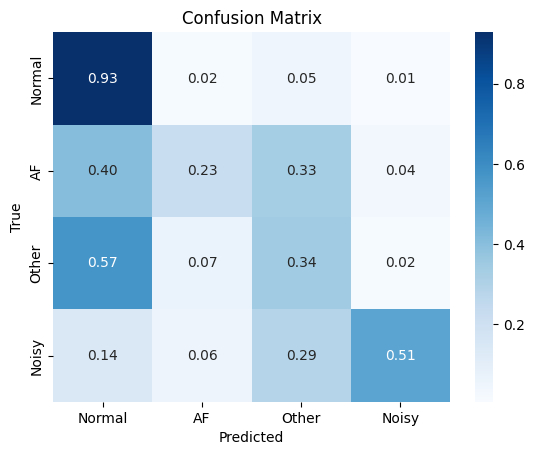

Validation Accuracy of VorgabeGRU with scale_only: 0.6494

Testing CNNwithSVM with scale_only
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:09,  9.00it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.97it/s]


Epoch 1: Train Loss: 0.9685, Train Acc: 63.27%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


Epoch 2: Train Loss: 0.8361, Train Acc: 68.74%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  9.04it/s]


Epoch 3: Train Loss: 0.7672, Train Acc: 71.46%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  9.00it/s]


Epoch 4: Train Loss: 0.7276, Train Acc: 72.81%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  8.96it/s]


Epoch 5: Train Loss: 0.6948, Train Acc: 73.74%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  8.99it/s]


Epoch 6: Train Loss: 0.6492, Train Acc: 75.11%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  9.03it/s]


Epoch 7: Train Loss: 0.6226, Train Acc: 76.66%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.96it/s]


Epoch 8: Train Loss: 0.6253, Train Acc: 75.89%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  8.95it/s]


Epoch 9: Train Loss: 0.5511, Train Acc: 78.92%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  9.08it/s]


Epoch 10: Train Loss: 0.5174, Train Acc: 80.79%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.96it/s]


Epoch 11: Train Loss: 0.4837, Train Acc: 82.27%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  8.94it/s]


Epoch 12: Train Loss: 0.4500, Train Acc: 83.59%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 13: Train Loss: 0.4120, Train Acc: 85.19%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 14: Train Loss: 0.3490, Train Acc: 88.67%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 15: Train Loss: 0.3463, Train Acc: 88.16%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  9.00it/s]


Epoch 16: Train Loss: 0.2731, Train Acc: 91.95%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  9.05it/s]


Epoch 17: Train Loss: 0.2821, Train Acc: 90.99%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


Epoch 18: Train Loss: 0.2378, Train Acc: 93.34%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.94it/s]


Epoch 19: Train Loss: 0.1790, Train Acc: 95.75%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  9.04it/s]


Epoch 20: Train Loss: 0.1542, Train Acc: 96.99%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 49.04it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 24.53it/s]


Final Validation Accuracy: 0.7174
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       544
           1       0.62      0.46      0.53        84
           2       0.57      0.58      0.58       264
           3       0.71      0.49      0.58        35

    accuracy                           0.72       927
   macro avg       0.67      0.59      0.62       927
weighted avg       0.71      0.72      0.71       927

Final Validation F1 Score: 0.7132


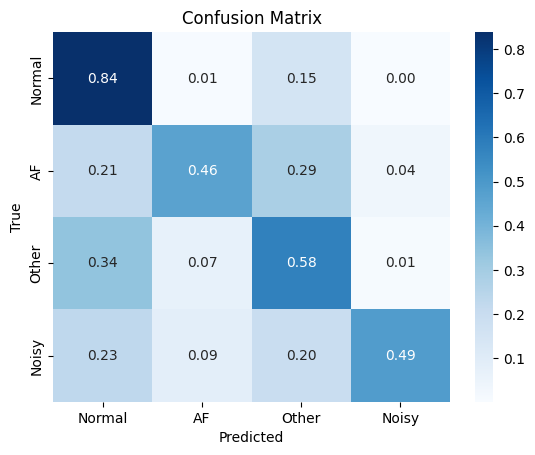

Validation Accuracy of CNNwithSVM with scale_only: 0.7132

Testing VorgabeGRU with warp_only
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:06<00:00, 13.81it/s]


Epoch 1: Train Loss: 1.3611, Train Acc: 56.85%


Epoch 2/20: 100%|██████████| 83/83 [00:06<00:00, 12.25it/s]


Epoch 2: Train Loss: 1.0068, Train Acc: 59.23%


Epoch 3/20: 100%|██████████| 83/83 [00:05<00:00, 14.43it/s]


Epoch 3: Train Loss: 0.9787, Train Acc: 59.31%


Epoch 4/20: 100%|██████████| 83/83 [00:06<00:00, 12.43it/s]


Epoch 4: Train Loss: 1.0026, Train Acc: 59.37%


Epoch 5/20: 100%|██████████| 83/83 [00:06<00:00, 13.43it/s]


Epoch 5: Train Loss: 0.9884, Train Acc: 59.73%


Epoch 6/20: 100%|██████████| 83/83 [00:13<00:00,  6.05it/s]


Epoch 6: Train Loss: 0.9632, Train Acc: 60.22%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  8.65it/s]


Epoch 7: Train Loss: 0.9463, Train Acc: 62.41%


Epoch 8/20: 100%|██████████| 83/83 [00:11<00:00,  7.24it/s]


Epoch 8: Train Loss: 0.9154, Train Acc: 63.67%


Epoch 9/20: 100%|██████████| 83/83 [00:07<00:00, 10.46it/s]


Epoch 9: Train Loss: 0.9165, Train Acc: 64.09%


Epoch 10/20: 100%|██████████| 83/83 [00:10<00:00,  7.65it/s]


Epoch 10: Train Loss: 0.9255, Train Acc: 63.77%


Epoch 11/20: 100%|██████████| 83/83 [00:07<00:00, 11.65it/s]


Epoch 11: Train Loss: 0.8892, Train Acc: 64.03%


Epoch 12/20: 100%|██████████| 83/83 [00:06<00:00, 13.46it/s]


Epoch 12: Train Loss: 0.8650, Train Acc: 65.69%


Epoch 13/20: 100%|██████████| 83/83 [00:06<00:00, 13.27it/s]


Epoch 13: Train Loss: 0.8496, Train Acc: 66.22%


Epoch 14/20: 100%|██████████| 83/83 [00:06<00:00, 12.93it/s]


Epoch 14: Train Loss: 0.8514, Train Acc: 66.47%


Epoch 15/20: 100%|██████████| 83/83 [00:05<00:00, 14.16it/s]


Epoch 15: Train Loss: 0.8165, Train Acc: 67.04%


Epoch 16/20: 100%|██████████| 83/83 [00:06<00:00, 12.39it/s]


Epoch 16: Train Loss: 0.8228, Train Acc: 66.68%


Epoch 17/20: 100%|██████████| 83/83 [00:05<00:00, 14.26it/s]


Epoch 17: Train Loss: 0.8250, Train Acc: 66.96%


Epoch 18/20: 100%|██████████| 83/83 [00:06<00:00, 12.11it/s]


Epoch 18: Train Loss: 0.8027, Train Acc: 67.65%


Epoch 19/20: 100%|██████████| 83/83 [00:05<00:00, 13.92it/s]


Epoch 19: Train Loss: 0.8340, Train Acc: 67.96%


Epoch 20/20: 100%|██████████| 83/83 [00:06<00:00, 12.28it/s]


Epoch 20: Train Loss: 0.7884, Train Acc: 69.29%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 49.81it/s]


Final Validation Accuracy: 0.6807
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       544
           1       0.53      0.10      0.16        84
           2       0.55      0.42      0.48       264
           3       0.55      0.69      0.61        35

    accuracy                           0.68       927
   macro avg       0.59      0.53      0.51       927
weighted avg       0.66      0.68      0.65       927

Final Validation F1 Score: 0.6470


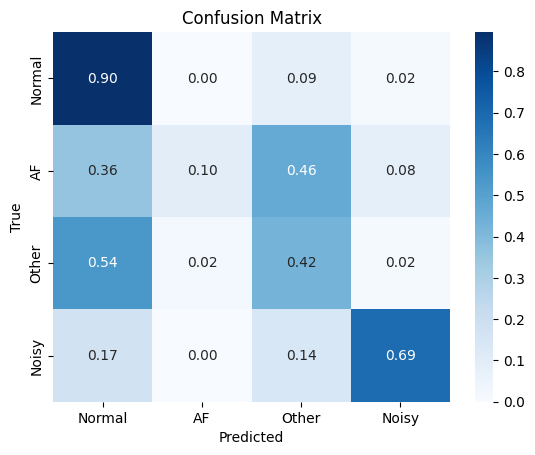

Validation Accuracy of VorgabeGRU with warp_only: 0.6470

Testing CNNwithSVM with warp_only
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:15,  5.22it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:12<00:00,  6.75it/s]


Epoch 1: Train Loss: 1.0130, Train Acc: 59.90%


Epoch 2/20: 100%|██████████| 83/83 [00:12<00:00,  6.72it/s]


Epoch 2: Train Loss: 0.8729, Train Acc: 66.20%


Epoch 3/20: 100%|██████████| 83/83 [00:12<00:00,  6.74it/s]


Epoch 3: Train Loss: 0.8042, Train Acc: 69.50%


Epoch 4/20: 100%|██████████| 83/83 [00:12<00:00,  6.84it/s]


Epoch 4: Train Loss: 0.7737, Train Acc: 70.24%


Epoch 5/20: 100%|██████████| 83/83 [00:12<00:00,  6.91it/s]


Epoch 5: Train Loss: 0.7595, Train Acc: 69.84%


Epoch 6/20: 100%|██████████| 83/83 [00:12<00:00,  6.90it/s]


Epoch 6: Train Loss: 0.7269, Train Acc: 72.12%


Epoch 7/20: 100%|██████████| 83/83 [00:12<00:00,  6.89it/s]


Epoch 7: Train Loss: 0.7130, Train Acc: 72.85%


Epoch 8/20: 100%|██████████| 83/83 [00:11<00:00,  7.02it/s]


Epoch 8: Train Loss: 0.7021, Train Acc: 72.35%


Epoch 9/20: 100%|██████████| 83/83 [00:11<00:00,  6.97it/s]


Epoch 9: Train Loss: 0.6968, Train Acc: 72.26%


Epoch 10/20: 100%|██████████| 83/83 [00:11<00:00,  6.93it/s]


Epoch 10: Train Loss: 0.6816, Train Acc: 73.53%


Epoch 11/20: 100%|██████████| 83/83 [00:12<00:00,  6.88it/s]


Epoch 11: Train Loss: 0.6655, Train Acc: 74.16%


Epoch 12/20: 100%|██████████| 83/83 [00:11<00:00,  6.96it/s]


Epoch 12: Train Loss: 0.6543, Train Acc: 74.31%


Epoch 13/20: 100%|██████████| 83/83 [00:11<00:00,  6.95it/s]


Epoch 13: Train Loss: 0.6484, Train Acc: 75.29%


Epoch 14/20: 100%|██████████| 83/83 [00:11<00:00,  6.94it/s]


Epoch 14: Train Loss: 0.6221, Train Acc: 75.91%


Epoch 15/20: 100%|██████████| 83/83 [00:12<00:00,  6.92it/s]


Epoch 15: Train Loss: 0.6144, Train Acc: 75.69%


Epoch 16/20: 100%|██████████| 83/83 [00:12<00:00,  6.90it/s]


Epoch 16: Train Loss: 0.6056, Train Acc: 76.62%


Epoch 17/20: 100%|██████████| 83/83 [00:12<00:00,  6.88it/s]


Epoch 17: Train Loss: 0.6050, Train Acc: 76.71%


Epoch 18/20: 100%|██████████| 83/83 [00:11<00:00,  6.98it/s]


Epoch 18: Train Loss: 0.6249, Train Acc: 75.00%


Epoch 19/20: 100%|██████████| 83/83 [00:11<00:00,  6.96it/s]


Epoch 19: Train Loss: 0.5755, Train Acc: 77.91%


Epoch 20/20: 100%|██████████| 83/83 [00:11<00:00,  6.95it/s]


Epoch 20: Train Loss: 0.5754, Train Acc: 77.82%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:05<00:00, 16.51it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 26.55it/s]


Final Validation Accuracy: 0.7616
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       544
           1       0.70      0.55      0.61        84
           2       0.70      0.51      0.59       264
           3       0.74      0.66      0.70        35

    accuracy                           0.76       927
   macro avg       0.73      0.66      0.69       927
weighted avg       0.75      0.76      0.75       927

Final Validation F1 Score: 0.7487


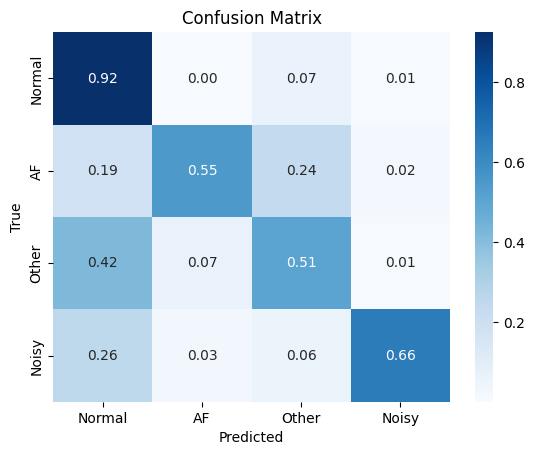

Validation Accuracy of CNNwithSVM with warp_only: 0.7487

All tests completed.
Best result:
Model: CNNwithSVM, Augmentation: shift_only, Accuracy: 0.7666


In [9]:
test_space = {
    "model": [
        VorgabeGRU,
        CNNwithSVM
    ],
    "augmentation": ["all", "noise_only", "shift_only", "scale_only", "warp_only"],
}

results = []
print("Starting tests with different configurations...")

device = "cuda" if torch.cuda.is_available() else "mps"

for augmentation in test_space["augmentation"]:
    train_set = ECGDataset(train_df, augmentation=augmentation)
    val_set = ECGDataset(val_df)
    train_loader = DataLoader(train_set,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              generator=torch.Generator().manual_seed(42))

    val_loader = DataLoader(val_set,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=False)

    for model_cls in test_space["model"]:
        print(f"Testing {model_cls.__name__} with {augmentation}")
        if issubclass(model_cls, VorgabeRNN):
            model = model_cls(
                hidden_size=128,
                num_layers=1,
                num_classes=NUM_CLASSES,
                n_fft=256,
                hop_length=128,
                dropout_rate=0.1,
            )
        else:
            model = model_cls(
                feature_size=50,
                num_classes=NUM_CLASSES
            )
        model.to(device)
        trained_model = train_model(model, train_loader, epochs=20, lr=0.001, batch_size_factor=4)
        f1 = evaluate_model(trained_model, val_loader, device)
        print(f"Macro F1 of {model_cls.__name__} with {augmentation}: {f1:.4f}\n")
        results.append({
            "model": model_cls.__name__,
            "augmentation": augmentation,
            "f1": f1,
        })
        del trained_model
        torch.cuda.empty_cache()
    del train_set, val_set, train_loader, val_loader

print("All tests completed.")
best_result = max(results, key=lambda x: x["f1"])
print(f"Best result:\nModel: {best_result['model']}, Augmentation: {best_result['augmentation']}, F1: {best_result['f1']:.4f}")

Starting tests with different configurations...
Testing VorgabeGRU with all
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:06<00:00, 12.33it/s]


Epoch 1: Train Loss: 1.2216, Train Acc: 56.76%


Epoch 2/20: 100%|██████████| 83/83 [00:07<00:00, 10.79it/s]


Epoch 2: Train Loss: 1.0207, Train Acc: 59.10%


Epoch 3/20: 100%|██████████| 83/83 [00:06<00:00, 11.89it/s]


Epoch 3: Train Loss: 1.0127, Train Acc: 58.95%


Epoch 4/20: 100%|██████████| 83/83 [00:08<00:00,  9.51it/s]


Epoch 4: Train Loss: 0.9916, Train Acc: 58.99%


Epoch 5/20: 100%|██████████| 83/83 [00:07<00:00, 10.91it/s]


Epoch 5: Train Loss: 0.9865, Train Acc: 60.42%


Epoch 6/20: 100%|██████████| 83/83 [00:06<00:00, 12.14it/s]


Epoch 6: Train Loss: 0.9742, Train Acc: 59.77%


Epoch 7/20: 100%|██████████| 83/83 [00:07<00:00, 10.89it/s]


Epoch 7: Train Loss: 0.9588, Train Acc: 61.29%


Epoch 8/20: 100%|██████████| 83/83 [00:06<00:00, 12.65it/s]


Epoch 8: Train Loss: 0.9255, Train Acc: 62.78%


Epoch 9/20: 100%|██████████| 83/83 [00:07<00:00, 11.11it/s]


Epoch 9: Train Loss: 0.9226, Train Acc: 64.43%


Epoch 10/20: 100%|██████████| 83/83 [00:06<00:00, 12.54it/s]


Epoch 10: Train Loss: 1.0012, Train Acc: 59.58%


Epoch 11/20: 100%|██████████| 83/83 [00:07<00:00, 11.14it/s]


Epoch 11: Train Loss: 0.9739, Train Acc: 61.29%


Epoch 12/20: 100%|██████████| 83/83 [00:06<00:00, 12.01it/s]


Epoch 12: Train Loss: 0.9487, Train Acc: 62.83%


Epoch 13/20: 100%|██████████| 83/83 [00:07<00:00, 11.21it/s]


Epoch 13: Train Loss: 0.9262, Train Acc: 63.35%


Epoch 14/20: 100%|██████████| 83/83 [00:07<00:00, 10.93it/s]


Epoch 14: Train Loss: 0.9210, Train Acc: 63.39%


Epoch 15/20: 100%|██████████| 83/83 [00:06<00:00, 12.19it/s]


Epoch 15: Train Loss: 0.8947, Train Acc: 64.15%


Epoch 16/20: 100%|██████████| 83/83 [00:07<00:00, 10.80it/s]


Epoch 16: Train Loss: 0.9532, Train Acc: 61.98%


Epoch 17/20: 100%|██████████| 83/83 [00:06<00:00, 12.32it/s]


Epoch 17: Train Loss: 0.8800, Train Acc: 65.37%


Epoch 18/20: 100%|██████████| 83/83 [00:07<00:00, 10.88it/s]


Epoch 18: Train Loss: 0.8685, Train Acc: 65.84%


Epoch 19/20: 100%|██████████| 83/83 [00:06<00:00, 12.07it/s]


Epoch 19: Train Loss: 0.8733, Train Acc: 66.49%


Epoch 20/20: 100%|██████████| 83/83 [00:07<00:00, 10.87it/s]


Epoch 20: Train Loss: 1.0183, Train Acc: 58.55%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 54.36it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5847
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       544
           1       1.00      0.01      0.02        84
           2       0.00      0.00      0.00       264
           3       0.34      0.49      0.40        35

    accuracy                           0.58       927
   macro avg       0.48      0.37      0.29       927
weighted avg       0.45      0.58      0.45       927

Final Validation F1 Score: 0.4503


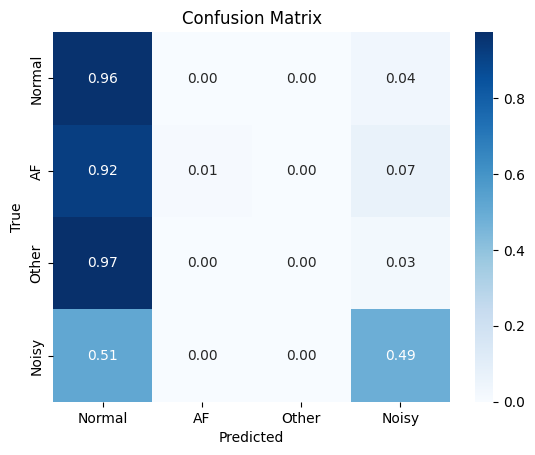

Macro F1 of VorgabeGRU with all: 0.4503

Testing CNNwithSVM with all
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   0%|          | 0/83 [00:00<?, ?it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:12<00:00,  6.44it/s]


Epoch 1: Train Loss: 1.0643, Train Acc: 58.13%


Epoch 2/20: 100%|██████████| 83/83 [00:12<00:00,  6.41it/s]


Epoch 2: Train Loss: 0.9411, Train Acc: 63.73%


Epoch 3/20: 100%|██████████| 83/83 [00:12<00:00,  6.47it/s]


Epoch 3: Train Loss: 0.8514, Train Acc: 67.54%


Epoch 4/20: 100%|██████████| 83/83 [00:12<00:00,  6.55it/s]


Epoch 4: Train Loss: 0.8203, Train Acc: 69.08%


Epoch 5/20: 100%|██████████| 83/83 [00:12<00:00,  6.61it/s]


Epoch 5: Train Loss: 0.8078, Train Acc: 68.83%


Epoch 6/20: 100%|██████████| 83/83 [00:12<00:00,  6.52it/s]


Epoch 6: Train Loss: 0.7688, Train Acc: 69.95%


Epoch 7/20: 100%|██████████| 83/83 [00:12<00:00,  6.50it/s]


Epoch 7: Train Loss: 0.7579, Train Acc: 71.17%


Epoch 8/20: 100%|██████████| 83/83 [00:12<00:00,  6.56it/s]


Epoch 8: Train Loss: 0.7471, Train Acc: 71.17%


Epoch 9/20: 100%|██████████| 83/83 [00:12<00:00,  6.49it/s]


Epoch 9: Train Loss: 0.7356, Train Acc: 71.46%


Epoch 10/20: 100%|██████████| 83/83 [00:12<00:00,  6.48it/s]


Epoch 10: Train Loss: 0.7145, Train Acc: 72.79%


Epoch 11/20: 100%|██████████| 83/83 [00:12<00:00,  6.46it/s]


Epoch 11: Train Loss: 0.7138, Train Acc: 73.10%


Epoch 12/20: 100%|██████████| 83/83 [00:12<00:00,  6.45it/s]


Epoch 12: Train Loss: 0.6979, Train Acc: 73.31%


Epoch 13/20: 100%|██████████| 83/83 [00:12<00:00,  6.41it/s]


Epoch 13: Train Loss: 0.6857, Train Acc: 73.72%


Epoch 14/20: 100%|██████████| 83/83 [00:12<00:00,  6.48it/s]


Epoch 14: Train Loss: 0.6918, Train Acc: 73.63%


Epoch 15/20: 100%|██████████| 83/83 [00:13<00:00,  6.37it/s]


Epoch 15: Train Loss: 0.6652, Train Acc: 74.39%


Epoch 16/20: 100%|██████████| 83/83 [00:12<00:00,  6.46it/s]


Epoch 16: Train Loss: 0.6655, Train Acc: 74.90%


Epoch 17/20: 100%|██████████| 83/83 [00:12<00:00,  6.44it/s]


Epoch 17: Train Loss: 0.6488, Train Acc: 74.79%


Epoch 18/20: 100%|██████████| 83/83 [00:12<00:00,  6.47it/s]


Epoch 18: Train Loss: 0.6531, Train Acc: 75.27%


Epoch 19/20: 100%|██████████| 83/83 [00:12<00:00,  6.48it/s]


Epoch 19: Train Loss: 0.6330, Train Acc: 75.59%


Epoch 20/20: 100%|██████████| 83/83 [00:12<00:00,  6.49it/s]


Epoch 20: Train Loss: 0.6557, Train Acc: 75.42%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:04<00:00, 17.44it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 26.35it/s]


Final Validation Accuracy: 0.7508
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       544
           1       0.71      0.42      0.53        84
           2       0.71      0.46      0.56       264
           3       0.72      0.66      0.69        35

    accuracy                           0.75       927
   macro avg       0.73      0.62      0.65       927
weighted avg       0.74      0.75      0.73       927

Final Validation F1 Score: 0.7298


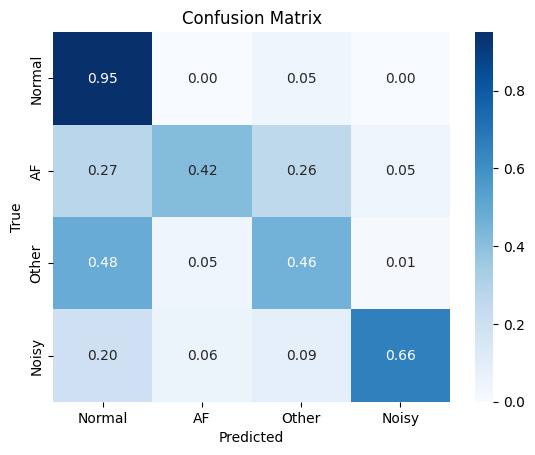

Macro F1 of CNNwithSVM with all: 0.7298

Testing VorgabeGRU with noise_only
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:04<00:00, 20.70it/s]


Epoch 1: Train Loss: 1.2487, Train Acc: 56.89%


Epoch 2/20: 100%|██████████| 83/83 [00:03<00:00, 24.76it/s]


Epoch 2: Train Loss: 1.0065, Train Acc: 59.52%


Epoch 3/20: 100%|██████████| 83/83 [00:03<00:00, 24.92it/s]


Epoch 3: Train Loss: 0.9883, Train Acc: 59.88%


Epoch 4/20: 100%|██████████| 83/83 [00:03<00:00, 21.08it/s]


Epoch 4: Train Loss: 0.9564, Train Acc: 61.31%


Epoch 5/20: 100%|██████████| 83/83 [00:03<00:00, 23.87it/s]


Epoch 5: Train Loss: 0.9452, Train Acc: 61.63%


Epoch 6/20: 100%|██████████| 83/83 [00:03<00:00, 25.04it/s]


Epoch 6: Train Loss: 0.9234, Train Acc: 62.78%


Epoch 7/20: 100%|██████████| 83/83 [00:03<00:00, 24.68it/s]


Epoch 7: Train Loss: 1.0208, Train Acc: 58.89%


Epoch 8/20: 100%|██████████| 83/83 [00:04<00:00, 20.16it/s]


Epoch 8: Train Loss: 0.9638, Train Acc: 60.30%


Epoch 9/20: 100%|██████████| 83/83 [00:03<00:00, 24.14it/s]


Epoch 9: Train Loss: 0.9362, Train Acc: 63.44%


Epoch 10/20: 100%|██████████| 83/83 [00:03<00:00, 24.33it/s]


Epoch 10: Train Loss: 0.9232, Train Acc: 63.39%


Epoch 11/20: 100%|██████████| 83/83 [00:03<00:00, 23.10it/s]


Epoch 11: Train Loss: 0.9003, Train Acc: 64.20%


Epoch 12/20: 100%|██████████| 83/83 [00:03<00:00, 21.54it/s]


Epoch 12: Train Loss: 0.8578, Train Acc: 66.01%


Epoch 13/20: 100%|██████████| 83/83 [00:03<00:00, 24.56it/s]


Epoch 13: Train Loss: 0.8100, Train Acc: 67.19%


Epoch 14/20: 100%|██████████| 83/83 [00:03<00:00, 24.63it/s]


Epoch 14: Train Loss: 0.7884, Train Acc: 67.67%


Epoch 15/20: 100%|██████████| 83/83 [00:03<00:00, 21.52it/s]


Epoch 15: Train Loss: 0.7528, Train Acc: 69.82%


Epoch 16/20: 100%|██████████| 83/83 [00:03<00:00, 22.92it/s]


Epoch 16: Train Loss: 0.7491, Train Acc: 69.95%


Epoch 17/20: 100%|██████████| 83/83 [00:03<00:00, 23.55it/s]


Epoch 17: Train Loss: 0.7404, Train Acc: 70.41%


Epoch 18/20: 100%|██████████| 83/83 [00:03<00:00, 24.09it/s]


Epoch 18: Train Loss: 0.7119, Train Acc: 71.61%


Epoch 19/20: 100%|██████████| 83/83 [00:04<00:00, 20.03it/s]


Epoch 19: Train Loss: 0.7039, Train Acc: 72.72%


Epoch 20/20: 100%|██████████| 83/83 [00:03<00:00, 23.88it/s]


Epoch 20: Train Loss: 0.8423, Train Acc: 66.58%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 53.33it/s]


Final Validation Accuracy: 0.6613
              precision    recall  f1-score   support

           0       0.68      0.92      0.79       544
           1       0.42      0.06      0.10        84
           2       0.61      0.30      0.40       264
           3       0.53      0.77      0.63        35

    accuracy                           0.66       927
   macro avg       0.56      0.51      0.48       927
weighted avg       0.63      0.66      0.61       927

Final Validation F1 Score: 0.6084


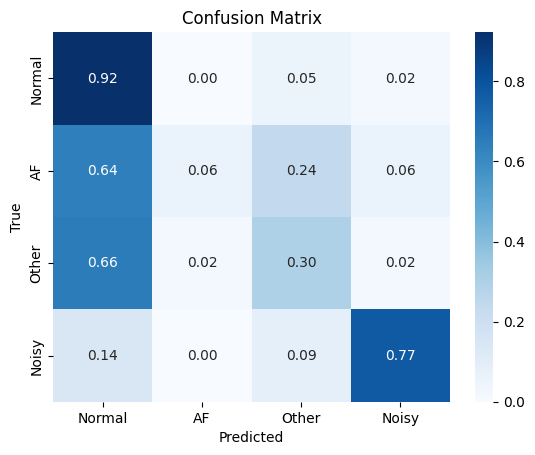

Macro F1 of VorgabeGRU with noise_only: 0.6084

Testing CNNwithSVM with noise_only
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:14,  5.79it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:10<00:00,  8.27it/s]


Epoch 1: Train Loss: 1.0374, Train Acc: 58.99%


Epoch 2/20: 100%|██████████| 83/83 [00:10<00:00,  8.19it/s]


Epoch 2: Train Loss: 0.8972, Train Acc: 65.86%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.45it/s]


Epoch 3: Train Loss: 0.8065, Train Acc: 69.73%


Epoch 4/20: 100%|██████████| 83/83 [00:10<00:00,  8.27it/s]


Epoch 4: Train Loss: 0.7432, Train Acc: 72.41%


Epoch 5/20: 100%|██████████| 83/83 [00:10<00:00,  8.27it/s]


Epoch 5: Train Loss: 0.7031, Train Acc: 73.46%


Epoch 6/20: 100%|██████████| 83/83 [00:10<00:00,  8.29it/s]


Epoch 6: Train Loss: 0.6539, Train Acc: 75.42%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  8.43it/s]


Epoch 7: Train Loss: 0.6209, Train Acc: 76.87%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.36it/s]


Epoch 8: Train Loss: 0.5864, Train Acc: 77.91%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  8.34it/s]


Epoch 9: Train Loss: 0.5354, Train Acc: 80.10%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.32it/s]


Epoch 10: Train Loss: 0.5235, Train Acc: 80.79%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.43it/s]


Epoch 11: Train Loss: 0.4992, Train Acc: 81.66%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  8.41it/s]


Epoch 12: Train Loss: 0.4438, Train Acc: 84.08%


Epoch 13/20: 100%|██████████| 83/83 [00:10<00:00,  8.30it/s]


Epoch 13: Train Loss: 0.4009, Train Acc: 85.47%


Epoch 14/20: 100%|██████████| 83/83 [00:10<00:00,  8.27it/s]


Epoch 14: Train Loss: 0.3500, Train Acc: 88.37%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.36it/s]


Epoch 15: Train Loss: 0.3273, Train Acc: 89.17%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  8.45it/s]


Epoch 16: Train Loss: 0.2802, Train Acc: 90.88%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.34it/s]


Epoch 17: Train Loss: 0.2760, Train Acc: 91.34%


Epoch 18/20: 100%|██████████| 83/83 [00:10<00:00,  8.26it/s]


Epoch 18: Train Loss: 0.2210, Train Acc: 93.98%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.33it/s]


Epoch 19: Train Loss: 0.1719, Train Acc: 96.33%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.54it/s]


Epoch 20: Train Loss: 0.1486, Train Acc: 97.26%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 30.41it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 25.76it/s]


Final Validation Accuracy: 0.7174
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       544
           1       0.58      0.46      0.52        84
           2       0.57      0.56      0.57       264
           3       0.72      0.51      0.60        35

    accuracy                           0.72       927
   macro avg       0.67      0.60      0.63       927
weighted avg       0.71      0.72      0.71       927

Final Validation F1 Score: 0.7130


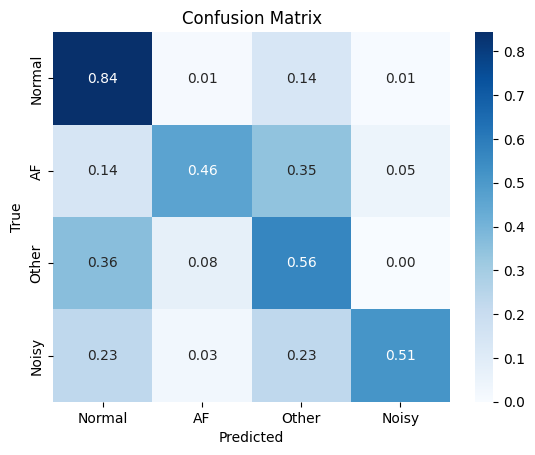

Macro F1 of CNNwithSVM with noise_only: 0.7130

Testing VorgabeGRU with shift_only
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 31.07it/s]


Epoch 1: Train Loss: 1.1958, Train Acc: 58.13%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 31.74it/s]


Epoch 2: Train Loss: 0.9834, Train Acc: 59.46%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 31.27it/s]


Epoch 3: Train Loss: 0.9749, Train Acc: 58.97%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 28.21it/s]


Epoch 4: Train Loss: 0.9575, Train Acc: 60.93%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 29.46it/s]


Epoch 5: Train Loss: 0.9293, Train Acc: 63.14%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 31.74it/s]


Epoch 6: Train Loss: 0.9136, Train Acc: 62.97%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 31.45it/s]


Epoch 7: Train Loss: 0.9119, Train Acc: 64.45%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 31.42it/s]


Epoch 8: Train Loss: 0.8379, Train Acc: 66.74%


Epoch 9/20: 100%|██████████| 83/83 [00:03<00:00, 27.08it/s]


Epoch 9: Train Loss: 0.8686, Train Acc: 66.34%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 30.71it/s]


Epoch 10: Train Loss: 0.8567, Train Acc: 66.22%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 31.53it/s]


Epoch 11: Train Loss: 0.8531, Train Acc: 65.38%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 31.58it/s]


Epoch 12: Train Loss: 0.8040, Train Acc: 67.84%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 30.79it/s]


Epoch 13: Train Loss: 0.7873, Train Acc: 68.49%


Epoch 14/20: 100%|██████████| 83/83 [00:03<00:00, 27.46it/s]


Epoch 14: Train Loss: 0.7941, Train Acc: 68.55%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 31.37it/s]


Epoch 15: Train Loss: 0.7563, Train Acc: 69.55%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 31.45it/s]


Epoch 16: Train Loss: 0.7930, Train Acc: 68.70%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 31.15it/s]


Epoch 17: Train Loss: 0.7507, Train Acc: 69.36%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 29.80it/s]


Epoch 18: Train Loss: 0.7434, Train Acc: 70.58%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 27.77it/s]


Epoch 19: Train Loss: 0.7514, Train Acc: 70.77%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 31.30it/s]


Epoch 20: Train Loss: 0.7507, Train Acc: 70.45%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 58.16it/s]


Final Validation Accuracy: 0.6915
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       544
           1       0.71      0.24      0.36        84
           2       0.54      0.62      0.58       264
           3       0.34      0.77      0.47        35

    accuracy                           0.69       927
   macro avg       0.61      0.61      0.56       927
weighted avg       0.72      0.69      0.69       927

Final Validation F1 Score: 0.6905


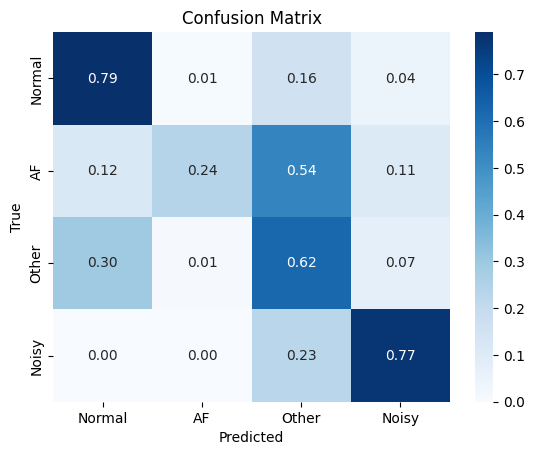

Macro F1 of VorgabeGRU with shift_only: 0.6905

Testing CNNwithSVM with shift_only
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:09,  9.09it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.92it/s]


Epoch 1: Train Loss: 1.0161, Train Acc: 60.85%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  9.05it/s]


Epoch 2: Train Loss: 0.8683, Train Acc: 67.35%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.95it/s]


Epoch 3: Train Loss: 0.7927, Train Acc: 70.05%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  8.92it/s]


Epoch 4: Train Loss: 0.7765, Train Acc: 70.45%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  9.03it/s]


Epoch 5: Train Loss: 0.7310, Train Acc: 71.53%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  9.04it/s]


Epoch 6: Train Loss: 0.6956, Train Acc: 73.69%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  8.93it/s]


Epoch 7: Train Loss: 0.6764, Train Acc: 73.99%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.95it/s]


Epoch 8: Train Loss: 0.6663, Train Acc: 75.30%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  9.10it/s]


Epoch 9: Train Loss: 0.6472, Train Acc: 75.21%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.92it/s]


Epoch 10: Train Loss: 0.6410, Train Acc: 75.67%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.94it/s]


Epoch 11: Train Loss: 0.6270, Train Acc: 76.31%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  9.03it/s]


Epoch 12: Train Loss: 0.5981, Train Acc: 77.08%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 13: Train Loss: 0.5887, Train Acc: 77.95%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.91it/s]


Epoch 14: Train Loss: 0.5849, Train Acc: 77.61%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.91it/s]


Epoch 15: Train Loss: 0.5675, Train Acc: 78.62%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  9.08it/s]


Epoch 16: Train Loss: 0.5477, Train Acc: 79.25%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.95it/s]


Epoch 17: Train Loss: 0.5415, Train Acc: 79.00%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.97it/s]


Epoch 18: Train Loss: 0.5178, Train Acc: 79.91%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  9.04it/s]


Epoch 19: Train Loss: 0.5055, Train Acc: 80.48%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 20: Train Loss: 0.5042, Train Acc: 81.34%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 62.14it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.39it/s]


Final Validation Accuracy: 0.7562
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       544
           1       0.70      0.52      0.60        84
           2       0.66      0.52      0.58       264
           3       0.75      0.60      0.67        35

    accuracy                           0.76       927
   macro avg       0.73      0.64      0.67       927
weighted avg       0.75      0.76      0.74       927

Final Validation F1 Score: 0.7441


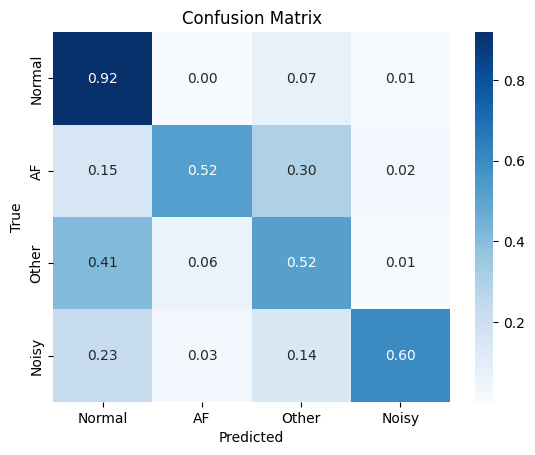

Macro F1 of CNNwithSVM with shift_only: 0.7441

Testing VorgabeGRU with scale_only
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:02<00:00, 28.69it/s]


Epoch 1: Train Loss: 1.2129, Train Acc: 56.26%


Epoch 2/20: 100%|██████████| 83/83 [00:02<00:00, 32.57it/s]


Epoch 2: Train Loss: 1.0305, Train Acc: 58.91%


Epoch 3/20: 100%|██████████| 83/83 [00:02<00:00, 32.68it/s]


Epoch 3: Train Loss: 1.0078, Train Acc: 59.29%


Epoch 4/20: 100%|██████████| 83/83 [00:02<00:00, 32.85it/s]


Epoch 4: Train Loss: 0.9900, Train Acc: 59.71%


Epoch 5/20: 100%|██████████| 83/83 [00:02<00:00, 30.88it/s]


Epoch 5: Train Loss: 0.9607, Train Acc: 61.35%


Epoch 6/20: 100%|██████████| 83/83 [00:02<00:00, 29.02it/s]


Epoch 6: Train Loss: 0.9280, Train Acc: 62.03%


Epoch 7/20: 100%|██████████| 83/83 [00:02<00:00, 32.36it/s]


Epoch 7: Train Loss: 0.9313, Train Acc: 62.47%


Epoch 8/20: 100%|██████████| 83/83 [00:02<00:00, 32.75it/s]


Epoch 8: Train Loss: 0.8816, Train Acc: 64.58%


Epoch 9/20: 100%|██████████| 83/83 [00:02<00:00, 32.73it/s]


Epoch 9: Train Loss: 0.8909, Train Acc: 65.84%


Epoch 10/20: 100%|██████████| 83/83 [00:02<00:00, 30.27it/s]


Epoch 10: Train Loss: 1.0348, Train Acc: 58.51%


Epoch 11/20: 100%|██████████| 83/83 [00:02<00:00, 28.75it/s]


Epoch 11: Train Loss: 1.0152, Train Acc: 57.33%


Epoch 12/20: 100%|██████████| 83/83 [00:02<00:00, 32.33it/s]


Epoch 12: Train Loss: 1.0102, Train Acc: 59.48%


Epoch 13/20: 100%|██████████| 83/83 [00:02<00:00, 32.18it/s]


Epoch 13: Train Loss: 0.9862, Train Acc: 59.98%


Epoch 14/20: 100%|██████████| 83/83 [00:02<00:00, 32.35it/s]


Epoch 14: Train Loss: 0.9964, Train Acc: 59.35%


Epoch 15/20: 100%|██████████| 83/83 [00:02<00:00, 29.39it/s]


Epoch 15: Train Loss: 0.9725, Train Acc: 59.98%


Epoch 16/20: 100%|██████████| 83/83 [00:02<00:00, 29.52it/s]


Epoch 16: Train Loss: 0.9545, Train Acc: 60.55%


Epoch 17/20: 100%|██████████| 83/83 [00:02<00:00, 32.80it/s]


Epoch 17: Train Loss: 0.9172, Train Acc: 63.19%


Epoch 18/20: 100%|██████████| 83/83 [00:02<00:00, 32.41it/s]


Epoch 18: Train Loss: 0.8579, Train Acc: 66.01%


Epoch 19/20: 100%|██████████| 83/83 [00:02<00:00, 32.43it/s]


Epoch 19: Train Loss: 0.8465, Train Acc: 67.50%


Epoch 20/20: 100%|██████████| 83/83 [00:02<00:00, 30.06it/s]


Epoch 20: Train Loss: 0.8397, Train Acc: 66.76%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 48.94it/s]


Final Validation Accuracy: 0.6429
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       544
           1       0.41      0.21      0.28        84
           2       0.61      0.13      0.21       264
           3       0.55      0.66      0.60        35

    accuracy                           0.64       927
   macro avg       0.56      0.49      0.47       927
weighted avg       0.62      0.64      0.57       927

Final Validation F1 Score: 0.5687


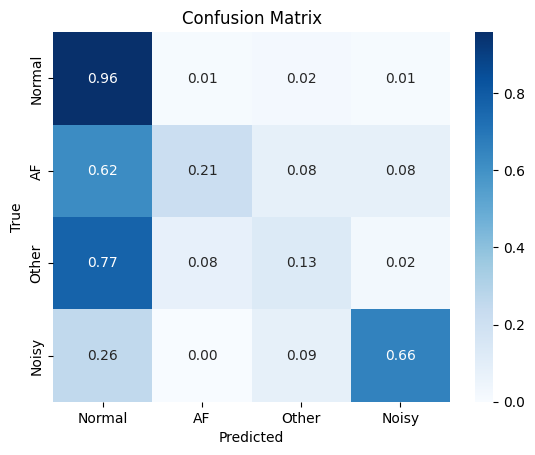

Macro F1 of VorgabeGRU with scale_only: 0.5687

Testing CNNwithSVM with scale_only
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:13,  5.92it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  9.06it/s]


Epoch 1: Train Loss: 1.0515, Train Acc: 60.45%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  9.00it/s]


Epoch 2: Train Loss: 0.9046, Train Acc: 66.17%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  9.00it/s]


Epoch 3: Train Loss: 0.8101, Train Acc: 69.10%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  9.10it/s]


Epoch 4: Train Loss: 0.7717, Train Acc: 71.02%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  9.03it/s]


Epoch 5: Train Loss: 0.7356, Train Acc: 71.73%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 6: Train Loss: 0.6967, Train Acc: 73.65%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  9.04it/s]


Epoch 7: Train Loss: 0.6760, Train Acc: 74.49%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  9.08it/s]


Epoch 8: Train Loss: 0.6521, Train Acc: 75.19%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 9: Train Loss: 0.6149, Train Acc: 76.73%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 10: Train Loss: 0.6065, Train Acc: 76.96%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  9.15it/s]


Epoch 11: Train Loss: 0.5941, Train Acc: 77.84%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 12: Train Loss: 0.5304, Train Acc: 80.35%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  8.91it/s]


Epoch 13: Train Loss: 0.4972, Train Acc: 81.72%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  9.03it/s]


Epoch 14: Train Loss: 0.4618, Train Acc: 83.19%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  8.98it/s]


Epoch 15: Train Loss: 0.4430, Train Acc: 83.74%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


Epoch 16: Train Loss: 0.4012, Train Acc: 86.02%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


Epoch 17: Train Loss: 0.3800, Train Acc: 86.67%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  9.03it/s]


Epoch 18: Train Loss: 0.3314, Train Acc: 89.03%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.88it/s]


Epoch 19: Train Loss: 0.2969, Train Acc: 90.67%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.91it/s]


Epoch 20: Train Loss: 0.2771, Train Acc: 91.60%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 62.44it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.10it/s]


Final Validation Accuracy: 0.7238
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       544
           1       0.59      0.48      0.53        84
           2       0.58      0.58      0.58       264
           3       0.68      0.43      0.53        35

    accuracy                           0.72       927
   macro avg       0.66      0.58      0.61       927
weighted avg       0.72      0.72      0.72       927

Final Validation F1 Score: 0.7190


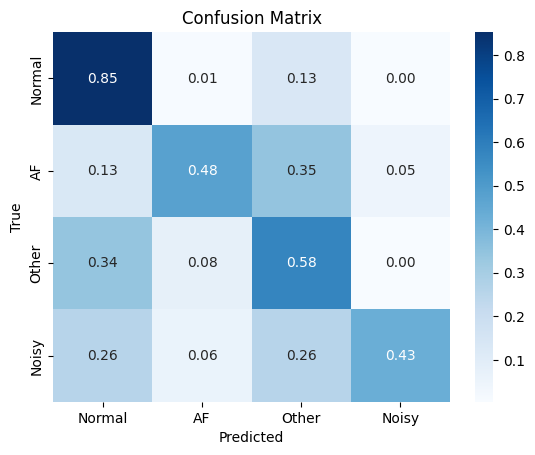

Macro F1 of CNNwithSVM with scale_only: 0.7190

Testing VorgabeGRU with warp_only
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:06<00:00, 12.62it/s]


Epoch 1: Train Loss: 1.2241, Train Acc: 58.02%


Epoch 2/20: 100%|██████████| 83/83 [00:05<00:00, 13.98it/s]


Epoch 2: Train Loss: 1.0067, Train Acc: 59.04%


Epoch 3/20: 100%|██████████| 83/83 [00:06<00:00, 12.02it/s]


Epoch 3: Train Loss: 0.9604, Train Acc: 60.57%


Epoch 4/20: 100%|██████████| 83/83 [00:05<00:00, 14.23it/s]


Epoch 4: Train Loss: 0.9023, Train Acc: 63.08%


Epoch 5/20: 100%|██████████| 83/83 [00:06<00:00, 12.81it/s]


Epoch 5: Train Loss: 0.9355, Train Acc: 63.65%


Epoch 6/20: 100%|██████████| 83/83 [00:06<00:00, 13.66it/s]


Epoch 6: Train Loss: 0.8792, Train Acc: 64.85%


Epoch 7/20: 100%|██████████| 83/83 [00:06<00:00, 13.38it/s]


Epoch 7: Train Loss: 0.9036, Train Acc: 63.96%


Epoch 8/20: 100%|██████████| 83/83 [00:06<00:00, 12.92it/s]


Epoch 8: Train Loss: 0.8208, Train Acc: 66.72%


Epoch 9/20: 100%|██████████| 83/83 [00:06<00:00, 13.43it/s]


Epoch 9: Train Loss: 0.8155, Train Acc: 67.86%


Epoch 10/20: 100%|██████████| 83/83 [00:06<00:00, 12.68it/s]


Epoch 10: Train Loss: 0.8750, Train Acc: 64.78%


Epoch 11/20: 100%|██████████| 83/83 [00:05<00:00, 14.92it/s]


Epoch 11: Train Loss: 0.8152, Train Acc: 67.63%


Epoch 12/20: 100%|██████████| 83/83 [00:06<00:00, 12.31it/s]


Epoch 12: Train Loss: 0.7883, Train Acc: 68.34%


Epoch 13/20: 100%|██████████| 83/83 [00:05<00:00, 14.30it/s]


Epoch 13: Train Loss: 0.7720, Train Acc: 68.89%


Epoch 14/20: 100%|██████████| 83/83 [00:06<00:00, 12.11it/s]


Epoch 14: Train Loss: 0.7765, Train Acc: 70.09%


Epoch 15/20: 100%|██████████| 83/83 [00:06<00:00, 13.77it/s]


Epoch 15: Train Loss: 0.7600, Train Acc: 69.76%


Epoch 16/20: 100%|██████████| 83/83 [00:06<00:00, 12.14it/s]


Epoch 16: Train Loss: 0.7689, Train Acc: 70.28%


Epoch 17/20: 100%|██████████| 83/83 [00:05<00:00, 13.89it/s]


Epoch 17: Train Loss: 0.7536, Train Acc: 70.37%


Epoch 18/20: 100%|██████████| 83/83 [00:06<00:00, 12.19it/s]


Epoch 18: Train Loss: 0.7349, Train Acc: 70.47%


Epoch 19/20: 100%|██████████| 83/83 [00:05<00:00, 14.53it/s]


Epoch 19: Train Loss: 0.7375, Train Acc: 71.90%


Epoch 20/20: 100%|██████████| 83/83 [00:06<00:00, 12.37it/s]


Epoch 20: Train Loss: 0.7760, Train Acc: 69.25%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 51.85it/s]


Final Validation Accuracy: 0.7098
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       544
           1       0.92      0.14      0.25        84
           2       0.64      0.44      0.52       264
           3       0.59      0.74      0.66        35

    accuracy                           0.71       927
   macro avg       0.72      0.56      0.56       927
weighted avg       0.72      0.71      0.68       927

Final Validation F1 Score: 0.6754


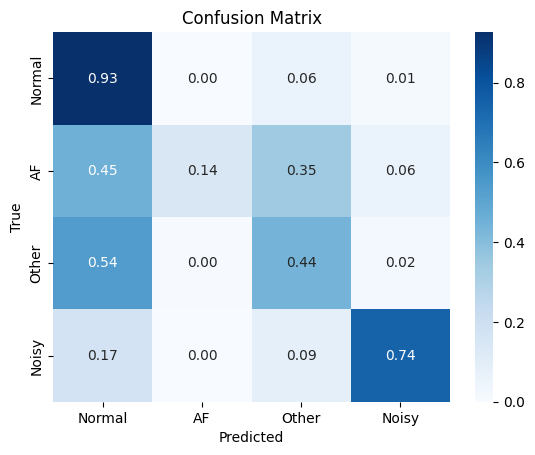

Macro F1 of VorgabeGRU with warp_only: 0.6754

Testing CNNwithSVM with warp_only
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   0%|          | 0/83 [00:00<?, ?it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:12<00:00,  6.78it/s]


Epoch 1: Train Loss: 1.0447, Train Acc: 59.69%


Epoch 2/20: 100%|██████████| 83/83 [00:12<00:00,  6.73it/s]


Epoch 2: Train Loss: 0.8926, Train Acc: 66.18%


Epoch 3/20: 100%|██████████| 83/83 [00:12<00:00,  6.80it/s]


Epoch 3: Train Loss: 0.8201, Train Acc: 69.00%


Epoch 4/20: 100%|██████████| 83/83 [00:12<00:00,  6.86it/s]


Epoch 4: Train Loss: 0.8025, Train Acc: 70.20%


Epoch 5/20: 100%|██████████| 83/83 [00:11<00:00,  7.01it/s]


Epoch 5: Train Loss: 0.7651, Train Acc: 70.73%


Epoch 6/20: 100%|██████████| 83/83 [00:11<00:00,  7.01it/s]


Epoch 6: Train Loss: 0.7395, Train Acc: 72.01%


Epoch 7/20: 100%|██████████| 83/83 [00:12<00:00,  6.84it/s]


Epoch 7: Train Loss: 0.7306, Train Acc: 72.73%


Epoch 8/20: 100%|██████████| 83/83 [00:12<00:00,  6.90it/s]


Epoch 8: Train Loss: 0.7242, Train Acc: 72.26%


Epoch 9/20: 100%|██████████| 83/83 [00:12<00:00,  6.88it/s]


Epoch 9: Train Loss: 0.6955, Train Acc: 73.72%


Epoch 10/20: 100%|██████████| 83/83 [00:12<00:00,  6.84it/s]


Epoch 10: Train Loss: 0.6905, Train Acc: 73.59%


Epoch 11/20: 100%|██████████| 83/83 [00:12<00:00,  6.89it/s]


Epoch 11: Train Loss: 0.6784, Train Acc: 74.28%


Epoch 12/20: 100%|██████████| 83/83 [00:12<00:00,  6.88it/s]


Epoch 12: Train Loss: 0.6682, Train Acc: 74.85%


Epoch 13/20: 100%|██████████| 83/83 [00:12<00:00,  6.89it/s]


Epoch 13: Train Loss: 0.6526, Train Acc: 74.92%


Epoch 14/20: 100%|██████████| 83/83 [00:12<00:00,  6.84it/s]


Epoch 14: Train Loss: 0.6364, Train Acc: 75.99%


Epoch 15/20: 100%|██████████| 83/83 [00:12<00:00,  6.84it/s]


Epoch 15: Train Loss: 0.6217, Train Acc: 75.91%


Epoch 16/20: 100%|██████████| 83/83 [00:11<00:00,  6.97it/s]


Epoch 16: Train Loss: 0.6165, Train Acc: 76.83%


Epoch 17/20: 100%|██████████| 83/83 [00:11<00:00,  6.97it/s]


Epoch 17: Train Loss: 0.6005, Train Acc: 76.37%


Epoch 18/20: 100%|██████████| 83/83 [00:11<00:00,  6.95it/s]


Epoch 18: Train Loss: 0.6046, Train Acc: 77.74%


Epoch 19/20: 100%|██████████| 83/83 [00:12<00:00,  6.87it/s]


Epoch 19: Train Loss: 0.5657, Train Acc: 77.93%


Epoch 20/20: 100%|██████████| 83/83 [00:12<00:00,  6.88it/s]


Epoch 20: Train Loss: 0.5790, Train Acc: 78.20%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:04<00:00, 18.29it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 21.25it/s]


Final Validation Accuracy: 0.7530
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       544
           1       0.76      0.45      0.57        84
           2       0.69      0.49      0.57       264
           3       0.74      0.71      0.72        35

    accuracy                           0.75       927
   macro avg       0.74      0.65      0.68       927
weighted avg       0.75      0.75      0.74       927

Final Validation F1 Score: 0.7366


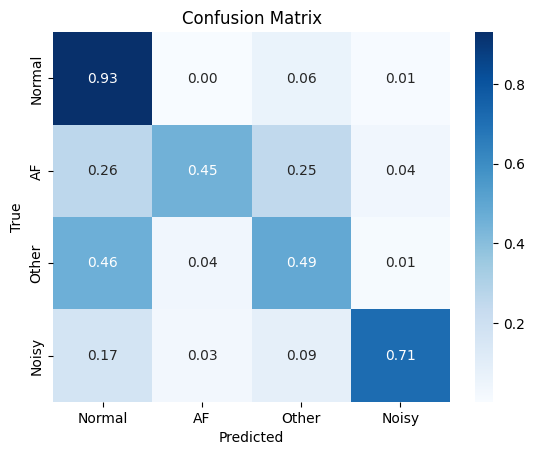

Macro F1 of CNNwithSVM with warp_only: 0.7366

All tests completed.
Best result:
Model: CNNwithSVM, Augmentation: shift_only, F1: 0.7441


In [10]:
# Re-run Experiment
test_space = {
    "model": [
        VorgabeGRU,
        CNNwithSVM
    ],
    "augmentation": ["all", "noise_only", "shift_only", "scale_only", "warp_only"],
}

results = []
print("Starting tests with different configurations...")

device = "cuda" if torch.cuda.is_available() else "cpu"

for augmentation in test_space["augmentation"]:
    train_set = ECGDataset(train_df, augmentation=augmentation)
    val_set = ECGDataset(val_df)
    train_loader = DataLoader(train_set,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              generator=torch.Generator().manual_seed(42))

    val_loader = DataLoader(val_set,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=False)

    for model_cls in test_space["model"]:
        print(f"Testing {model_cls.__name__} with {augmentation}")
        if issubclass(model_cls, VorgabeRNN):
            model = model_cls(
                hidden_size=128,
                num_layers=1,
                num_classes=NUM_CLASSES,
                n_fft=256,
                hop_length=128,
                dropout_rate=0.1,
            )
        else:
            model = model_cls(
                feature_size=50,
                num_classes=NUM_CLASSES
            )
        model.to(device)
        trained_model = train_model(model, train_loader, epochs=20, lr=0.001, batch_size_factor=4)
        f1 = evaluate_model(trained_model, val_loader, device)
        print(f"Macro F1 of {model_cls.__name__} with {augmentation}: {f1:.4f}\n")
        results.append({
            "model": model_cls.__name__,
            "augmentation": augmentation,
            "f1": f1,
        })
        del trained_model
        torch.cuda.empty_cache()
    del train_set, val_set, train_loader, val_loader

print("All tests completed.")
best_result = max(results, key=lambda x: x["f1"])
print(f"Best result:\nModel: {best_result['model']}, Augmentation: {best_result['augmentation']}, F1: {best_result['f1']:.4f}")

Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:14,  5.62it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  9.01it/s]


Epoch 1: Train Loss: 1.0132, Train Acc: 61.96%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  9.10it/s]


Epoch 2: Train Loss: 0.8613, Train Acc: 68.09%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.99it/s]


Epoch 3: Train Loss: 0.7756, Train Acc: 70.32%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  8.87it/s]


Epoch 4: Train Loss: 0.7443, Train Acc: 72.20%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  8.96it/s]


Epoch 5: Train Loss: 0.7204, Train Acc: 72.83%


Epoch 6/20: 100%|██████████| 83/83 [00:10<00:00,  8.25it/s]


Epoch 6: Train Loss: 0.6892, Train Acc: 74.60%


Epoch 7/20: 100%|██████████| 83/83 [00:10<00:00,  7.86it/s]


Epoch 7: Train Loss: 0.6865, Train Acc: 74.66%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  9.10it/s]


Epoch 8: Train Loss: 0.6442, Train Acc: 75.53%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  9.16it/s]


Epoch 9: Train Loss: 0.6395, Train Acc: 76.20%


Epoch 10/20: 100%|██████████| 83/83 [00:09<00:00,  9.04it/s]


Epoch 10: Train Loss: 0.6281, Train Acc: 76.16%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  9.05it/s]


Epoch 11: Train Loss: 0.6232, Train Acc: 76.05%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  9.15it/s]


Epoch 12: Train Loss: 0.5966, Train Acc: 77.42%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 13: Train Loss: 0.5814, Train Acc: 78.10%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  8.72it/s]


Epoch 14: Train Loss: 0.5757, Train Acc: 78.48%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  9.10it/s]


Epoch 15: Train Loss: 0.5639, Train Acc: 79.42%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  9.08it/s]


Epoch 16: Train Loss: 0.5518, Train Acc: 79.65%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.76it/s]


Epoch 17: Train Loss: 0.5294, Train Acc: 80.58%


Epoch 18/20: 100%|██████████| 83/83 [00:09<00:00,  8.47it/s]


Epoch 18: Train Loss: 0.5316, Train Acc: 80.67%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  9.15it/s]


Epoch 19: Train Loss: 0.5406, Train Acc: 79.36%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  9.04it/s]


Epoch 20: Train Loss: 0.5102, Train Acc: 80.90%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:01<00:00, 59.12it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 29.87it/s]


Final Validation Accuracy: 0.7443
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       544
           1       0.70      0.46      0.56        84
           2       0.66      0.48      0.56       264
           3       0.70      0.60      0.65        35

    accuracy                           0.74       927
   macro avg       0.71      0.62      0.65       927
weighted avg       0.73      0.74      0.73       927

Final Validation F1 Score: 0.7280


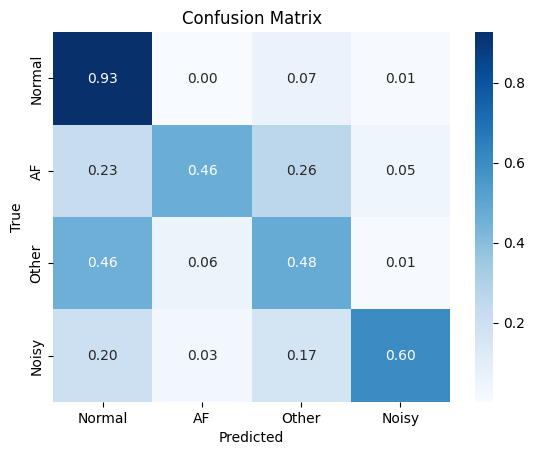

In [21]:
train_set = ECGDataset(train_df, augmentation="shift_only")
val_set = ECGDataset(val_df)
train_loader = DataLoader(train_set,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(42))

val_loader = DataLoader(val_set,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=False)
model = CNNwithSVM(
    feature_size=50,
    num_classes=NUM_CLASSES
)
model.to(device)
trained_model = train_model(model, train_loader, epochs=20, lr=0.001, batch_size_factor=4)
f1 = evaluate_model(trained_model, val_loader, device)

In [22]:
test_set = TestECGDataset(test_df)
test_loader = DataLoader(test_set,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=False)
all_predictions = []
trained_model.eval()

with torch.no_grad():
  for signals in tqdm(test_loader):
        signals = signals.unsqueeze(1).to(device)
        features = trained_model.cnn_feature_extractor(signals).cpu().numpy()
        predictions = model.svm.predict(features)
        all_predictions.extend(predictions)

prediction_df = pd.DataFrame(all_predictions)
prediction_df.to_csv("augment.csv", index=False)

100%|██████████| 42/42 [00:06<00:00,  6.96it/s]
